# Présentation des data

## Environnement

Nous utilisons Anaconda comme environnement virtuel afin d'utiliser les bibliothèques en C pour Cuda, car par l'import de christofides, nous utilisons PyCuda.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandasql as ps
import seaborn as sns

import itertools
import folium
import math
import openpyxl
import os
import pickle
import random
import scipy         
import sklearn
import christofides

from collections import OrderedDict, deque
from seaborn import color_palette
from sklearn import preprocessing

## Présentation des données

Nous avons vérifié que nous avons 17 ';' sur chacune des lignes, ainsi nous pouvons importer le fichier dans un cadre de données. Nous régénérons la colonne id, puisqu'il n'est pas précisé qu'il s'agissait d'un identifiant pour les arbres de la ville et qu'ils sont trop particulier.

In [2]:
data_orig = pd.read_csv('data.csv', sep=';')
data_orig.drop('id', axis=1, inplace=True)
data = data_orig.copy()
#data.drop('numero', axis=1, inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  object 
 1   domanialite          200136 non-null  object 
 2   arrondissement       200137 non-null  object 
 3   complement_addresse  30902 non-null   object 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  object 
 6   id_emplacement       200137 non-null  object 
 7   libelle_francais     198640 non-null  object 
 8   genre                200121 non-null  object 
 9   espece               198385 non-null  object 
 10  variete              36777 non-null   object 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  132932 non-null  object 
 14  remarquable          137039 non-null  float64
 15  geo_point_2d_a   

## Données Manquantes

Nous réglons les problèmes liés aux données manquantes de la manière suivante :

In [4]:
data['remarquable'].fillna(value=-1, inplace=True)
data['remarquable'] = data['remarquable'].map({0.:False, 1.:True})
data['remarquable'] = data['remarquable'].convert_dtypes(convert_integer=True)

Pour les colonnes "arrondissement"…, qui n'ont pas de valeurs nulles, nous forçons la conversion

In [5]:
colonnes = ['arrondissement', 'type_emplacement', 'lieu', 'id_emplacement']
for col in colonnes:
    data[col] = data[col].convert_dtypes(convert_string=True)

Pour les colonnes "stade_developpement"…, comme ce sont des strings, nous remplaçons les valeurs nulles par deux quote.

In [6]:
colonnes = ['stade_developpement', 'espece', 'variete', 'genre', 'libelle_francais',\
            'complement_addresse', 'domanialite']
for col in colonnes:
    data[col].fillna(value="", inplace=True)
    data[col] = data[col].convert_dtypes(convert_string=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  string 
 1   domanialite          200137 non-null  string 
 2   arrondissement       200137 non-null  string 
 3   complement_addresse  200137 non-null  string 
 4   numero               0 non-null       float64
 5   lieu                 200137 non-null  string 
 6   id_emplacement       200137 non-null  string 
 7   libelle_francais     200137 non-null  string 
 8   genre                200137 non-null  string 
 9   espece               200137 non-null  string 
 10  variete              200137 non-null  string 
 11  circonference_cm     200137 non-null  int64  
 12  hauteur_m            200137 non-null  int64  
 13  stade_developpement  200137 non-null  string 
 14  remarquable          137039 non-null  boolean
 15  geo_point_2d_a   

### Résolution d'une ligne de domanialité vide

Nous remarquons qu'une ligne ne comporte pas de domanialité, mais elle semble, d'après son lieu, être un jardin.

In [8]:
data.loc[data['domanialite'] == ""]

,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,Arbre,,PARIS 20E ARRDT,,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,203006,Chimonanthe,Chimonanthus,praecox,,35,4,JA,False,48.849547,2.41419


In [9]:
mask = data['domanialite'] == ''
data.loc[mask,'domanialite'] = 'Jardin'

In [10]:
data.iloc[197239]

type_emplacement                                                   Arbre
domanialite                                                       Jardin
arrondissement                                           PARIS 20E ARRDT
complement_addresse                                                     
numero                                                               NaN
lieu                   JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...
id_emplacement                                                    203006
libelle_francais                                             Chimonanthe
genre                                                       Chimonanthus
espece                                                           praecox
variete                                                                 
circonference_cm                                                      35
hauteur_m                                                              4
stade_developpement                                

De même pour les variétés non-saisie :

In [11]:
mask = data['variete'] == ''
data.loc[mask,'variete'] = 'n. sp.'
mask = data['espece'] == ''
data.loc[mask,'espece'] = 'n. sp.'
mask = data['libelle_francais'] == ''
data.loc[mask,'libelle_francais'] = 'n. sp.'
mask = data['genre'] == ''
data.loc[mask,'genre'] = 'n. sp.'

### Une catégorie pour les valeurs non-saisie dans les stades de développement

Pour y arriver, nous avons observer les moyennes des arbres de la catégorie vide, et comme elles sont proches des catégories 'J' et 'JA' nous l'appelerons 'P' pour particulier.

In [12]:
data.stade_developpement = data.stade_developpement.map({'':'P', 'A':'A','JA':'JA','M':'M','J':'J'})

In [13]:
data['stade_developpement'] = data['stade_developpement'].convert_dtypes()

In [14]:
data.stade_developpement.unique()

<StringArray>
['P', 'A', 'J', 'M', 'JA']
Length: 5, dtype: string

Comme la colonne de stade de développement est une variable qualitative ordonnée, nous créons une colonne de sa valeur en chiffre pour un usage quantitatif de la variable car l'âge est quantitatif.

In [15]:
data['sta_dev_num'] = data.stade_developpement.map({'J':1, 'P':2, 'JA':3, 'A':4, 'M':5})

# 2) Démarche méthodologique d'analyse de données

## Résolution des données aberrantes

### Analyse Univariée

Notre analyse va nous servir à détecter les erreurs dans la base de données, qui sont autant anomalies ("outliers") ou de données aberrantes qui peuvent nous conduire à de fausses conclusions sur les éléments de notre analyse. Nous analyserons les colonnes circonférence en centimètre, et hauteur en mètre. Les ordres de grandeurs sont indiqués dans les lignes min/max du tableau ci-dessous. À noter que nous commençons d'abord par décrire les données sans filtres :

In [16]:
data[['circonference_cm','hauteur_m']].describe()

,circonference_cm,hauteur_m
count,200137.000000,200137.000000
mean,83.380479,13.110509
std,673.190213,1971.217387
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,250255.000000,881818.000000


### Intervalle interquartile

$Q_i = Q_3 - Q_1$ nous donne l'intervalle interquartile. L'intervalle minimum de confiance est $Q_i \times 1.5$, c'est la limite intérieur. De plus l'intervalle maximum de confiance est $Q_i \times 3$. Nous réglons nos bornes selon cette formule : pour la circonférence le maximum de confiance est $255$, alors que pour la hauteur le maximum est $21$.

Ci-dessus, la ligne max nous permet de raisonner sur la présence d'aberrations et dans les prochains paragraphes, en ajustant les valeurs d'exclusions en multipliant par 3,5 , nous allons faire une analyse univariée pour la circonférence et la hauteur des arbres de la ville de Paris. Nous avons pris la circonférence entre $]0, 255] centimètres$, la hauteur entre $]0, 21] mètres$, puis les remarquables avec une valeur Vrai (dans un cas spécialement adapté ou la corrélation est évaluée entre la hauteur et la circonférence).

#### La circonférence

D'après le graphique et les résultats qui suivent, la circonférence de la population est une distribution dont le maximum est de $255 cm$ pour une moyenne de 88 cm et un écart type de $52 cm$ de part et d'autre de la moyenne. L'allure et la répartition de la distribution de la population est une asymétrie vers la droite, et le plus fréquemment, la circonférence est de 20 cm. L'échantillon considéré est de $171801$ arbres.

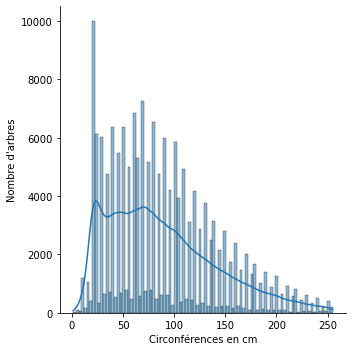

In [17]:
a = data.loc[(data["circonference_cm"] <= 255) & (data["circonference_cm"] > 0)]
g = sns.displot(data=a, x="circonference_cm", kde=True)
g.set_axis_labels("Circonférences en cm", "Nombre d'arbres")
g.set_titles("La distribution des circonférences")

In [18]:
a["circonference_cm"].describe()

count    171801.000000
mean         88.451965
std          52.976410
min           1.000000
25%          45.000000
50%          80.000000
75%         120.000000
max         255.000000
Name: circonference_cm, dtype: float64

In [19]:
a["circonference_cm"].mode()

0    20
dtype: int64

In [20]:
scipy.stats.skew(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.7695227895406083

In [21]:
scipy.stats.kurtosis(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.027890140940736163

#### La hauteur

La distribution est irrégulière, mais contient $155743$ arbres après filtrage des données aberrantes. La hauteur maximale est $21$ mètres et la moyenne est de $9,9$ mètres, tout comme le mode et la médiane. Par contre l'asymétrie est positive, donc vers la droite mais sa valeur est inférieur à $1$, comme l'est aussi son kurtosis. Visuellement, il serait difficile de dire qu'ici s'applique le théorème de limite centrale car nous n'avons pas à première vue une Gaussienne.


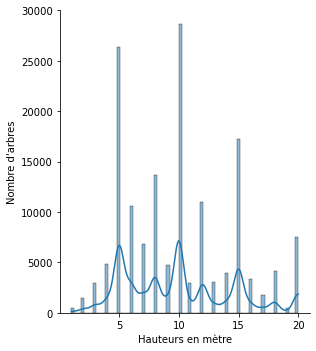

In [22]:
b = data.loc[(data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)]
h = sns.displot(data=b, x="hauteur_m", kde=True, height=5, aspect=.9)
h.set_titles("La distribution des hauteurs en mètre")
h.set_axis_labels("Hauteurs en mètre", "Nombre d'arbres")


In [23]:
b["hauteur_m"].describe()

count    155743.000000
mean          9.928016
std           4.546542
min           1.000000
25%           6.000000
50%          10.000000
75%          13.000000
max          20.000000
Name: hauteur_m, dtype: float64

In [24]:
b["hauteur_m"].mode()

0    10
dtype: int64

In [25]:
scipy.stats.skew(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

0.4872105232672621

In [26]:
scipy.stats.kurtosis(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.6014377033875058

In [27]:
data_filtre = pd.read_excel('data/data_filtre.xlsx')

<AxesSubplot:xlabel='Hauteurs en mètre'>

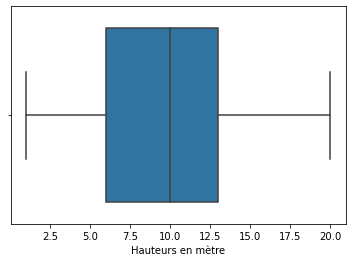

In [28]:
#boxplot les hauteurs des arbres
sns.boxplot(x="Hauteurs en mètre",data=data_filtre.rename(columns={'hauteur_m': 'Hauteurs en mètre'}))

<AxesSubplot:xlabel='Circonférences en cm'>

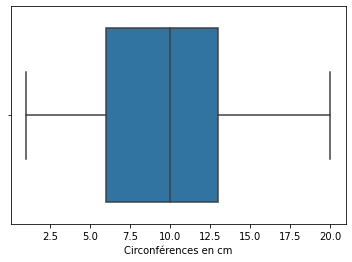

In [29]:
#boxplot les hauteurs des arbres
sns.boxplot(x="Circonférences en cm",data=data_filtre.rename(columns={'hauteur_m': 'Circonférences en cm'}))

#### Calculer l'écart type, la moyenne dans un tableau

Il est possible de se passer de la méthode info pour construire un algorithme plus puissant afin d'observer le plus d'information sur les tables :

In [30]:
def informations(data):
    # Header
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('#' , '|' , 'Column', '|', 'Dtype', '|', 'Unique', '|', 'Count Non-Null','|','Mean','|','Std','|'))
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('---' , '|' , '------', '|', '-----', '|', '------', '|', '--------------','|','----','|','---','|'))
    # dtypes information
    dtypes_uniques = set() # Collection of unique elements
    dtypes_listes = [] # list of complete data columns
    memory_usage = 0 # in MB
    for it, col in enumerate(data.columns): # Feed the set and the list
        dtypes_listes.append(str(data[col].dtype))
        if str(data[col].dtype) not in dtypes_uniques:
            dtypes_uniques.add(str(data[col].dtype))
        # Table body
        print('{:^3}{:<1}{:<20}{:<1}{:^9}{:>1}{:<6}{:<1}{:<15}{:<1}{:<7.5}{:<1}{:<7.5}{:<1}'.format(\
                                                str(it), '|' , col, '|',\
                                                str(data[col].dtype), '|', str(len(data[col].unique())),\
                                                '|',str(data[col].count()) + ' Non-null','|',\
                                                str(data[col].mean())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|',\
                                                str(data[col].std())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|'))
        
        # Collect informatives on disk usage by observation onto the data column
        memory_usage += int(data[col].memory_usage(index=True, deep=True))
    # Blend of set and list to print the information line as usual
    dtypes_string = ''
    for x in dtypes_uniques:
        dtypes_string += '{}({}), '.format(x, dtypes_listes.count(x))
    print('\ndtypes: {}'.format(dtypes_string))
    # Digit format to write mem usage in comprehensive format
    print('\nmemory usage: {:.4} MB\n'.format(memory_usage / (1024*1024)))



Nous calculons d'abord quelques détails pour profiler un peu mieux nos données, puis nous créons un rapport au format pdf pour étudier nos données.

Enuite 
À partir de nos jeux de données produites nous calculons les moyennes et les écarts types par la formules de la fonction information() que nous venons de definir dans la cellule au-dessus



In [31]:
informations(data_orig) # Nos données comportant des données aberrantes

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | object  |1     |200137 Non-null|       |       |
 1 |domanialite         | object  |10    |200136 Non-null|       |       |
 2 |arrondissement      | object  |25    |200137 Non-null|       |       |
 3 |complement_addresse | object  |3796  |30902 Non-null |       |       |
 4 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 5 |lieu                | object  |6921  |200137 Non-null|       |       |
 6 |id_emplacement      | object  |69040 |200137 Non-null|       |       |
 7 |libelle_francais    | object  |193   |198640 Non-null|       |       |
 8 |genre               | object  |176   |200121 Non-null|       |       |
 9 |espece              | object  |540   |198385 Non-null|       |       |
10 |variete             | object  |437   |36777 Non-null |       |       |
11 |circonference_cm    |

In [32]:
informations(data_filtre)  # Nos données ayant été sélectionner dans un intervalle de confiance

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |Unnamed: 0          |  int64  |154067|154067 Non-null|10781  |54100  |
 1 |type_emplacement    | object  |1     |154067 Non-null|       |       |
 2 |domanialite         | object  |9     |154067 Non-null|       |       |
 3 |arrondissement      | object  |25    |154067 Non-null|       |       |
 4 |complement_addresse | object  |3611  |29870 Non-null |       |       |
 5 |numero              | float64 |1     |0 Non-null     |nan    |nan    |
 6 |lieu                | object  |5389  |154067 Non-null|       |       |
 7 |id_emplacement      | object  |46578 |154067 Non-null|       |       |
 8 |libelle_francais    | object  |170   |154067 Non-null|       |       |
 9 |genre               | object  |146   |154067 Non-null|       |       |
10 |espece              | object  |375   |154067 Non-null|       |       |
11 |variete             |

### Analyse Bivariée

#### Régression linéaire entre la hauteur et la circonférence

En considérant l'expression de la circonférence d'après la hauteur, nous pouvons constater une corrélation positive entre le données quantitative, autant pour les arbres remarquables, que les premiers. Ainsi nous définissons les données filtrées dans une variable par copy profonde. Le coefficient $\beta$ est de $10^{-1}$ et donc un arbre de 1 mètre de circonférence peut faire en moyenne 10 mètres.

In [33]:
"""
data_filtre = data.loc[((data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 255) & (data["circonference_cm"] > 0))].copy()
data_filtre.to_excel('data/data_filtre.xlsx')
"""

'\ndata_filtre = data.loc[((data["hauteur_m"] < 21) & (data["hauteur_m"] > 0))                           & ((data["circonference_cm"] < 255) & (data["circonference_cm"] > 0))].copy()\ndata_filtre.to_excel(\'data/data_filtre.xlsx\')\n'

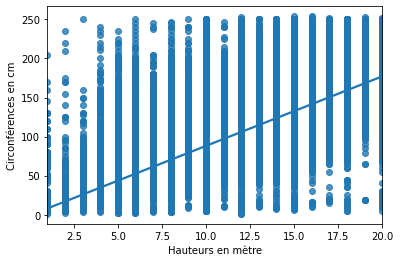

In [34]:
sns.regplot( x="Hauteurs en mètre", y="Circonférences en cm", 
            data=data_filtre.rename(columns={'hauteur_m':'Hauteurs en mètre',
                                       'circonference_cm': 'Circonférences en cm'}));

Maintenant que nous avons nettoyer nos données, nous pouvons regarder à l'intérieur des catégories, pour apprécier l'hétérogénéité des hauteurs, par exemple selon le stade de développement pour le genre Eucalyptus.

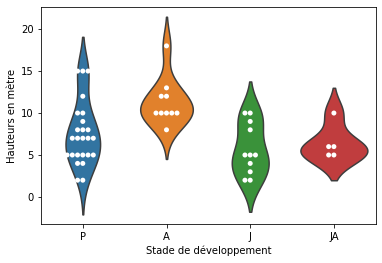

In [35]:
ax = sns.violinplot(x="Stade de développement", y="Hauteurs en mètre", 
                    data=data_filtre.loc[data_filtre['genre']=='Eucalyptus']
                    .rename(columns={'hauteur_m':'Hauteurs en mètre',
                                       'stade_developpement': 'Stade de développement'}), inner=None)

ax = sns.swarmplot(x="Stade de développement", y="Hauteurs en mètre", 
                   data=data_filtre.loc[data_filtre['genre']=='Eucalyptus']
                   .rename(columns={'hauteur_m':'Hauteurs en mètre',
                                       'stade_developpement': 'Stade de développement'}),

                   color="white", edgecolor="gray")

Ou encore voir que les domanialités ont différentes distributions en hauteur pour les platanes.

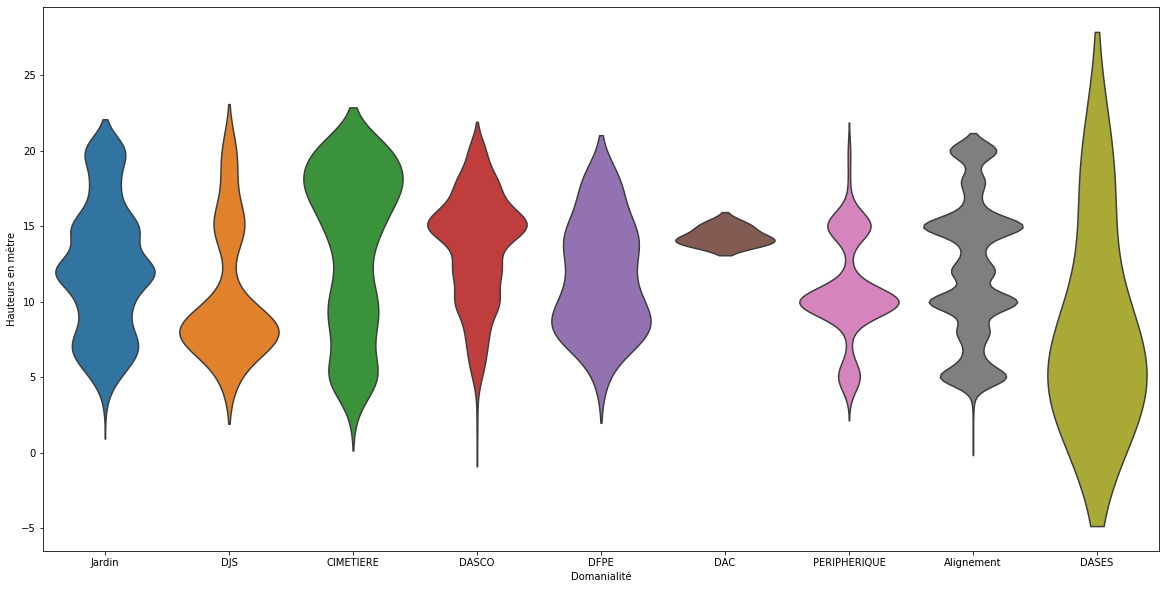

In [36]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="Domanialité", y="Hauteurs en mètre", data=data_filtre.loc[data_filtre['libelle_francais']=='Platane']
                    .rename(columns={'hauteur_m':'Hauteurs en mètre',
                                       'domanialite': 'Domanialité'}), inner=None, scale='width')
plt.show()

Et même que les domanialités ont différentes distributions en stade de développement. Notons que le périphérique
est très orienté sur un seul stade de développement, celui dont les hauteurs et les circonférences sont autant du groupe qui n'a pas encore été saisie.

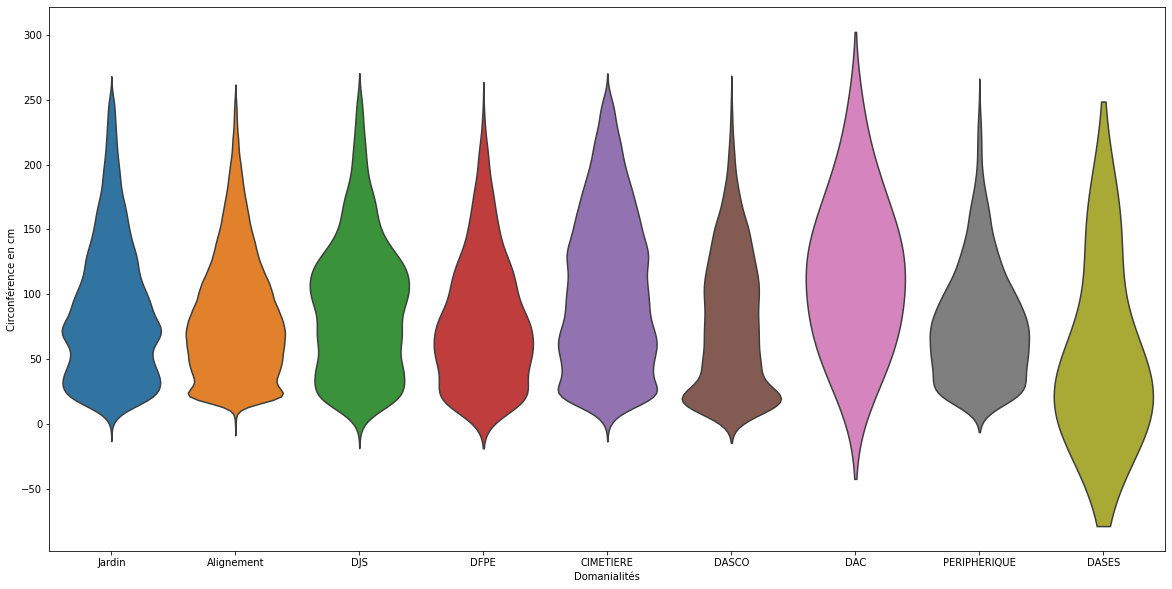

In [37]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="Domanialités", y="Circonférence en cm", data=data_filtre
                    .rename(columns={'circonference_cm':'Circonférence en cm',
                                       'domanialite': 'Domanialités'}), inner=None, scale='width')
plt.show()

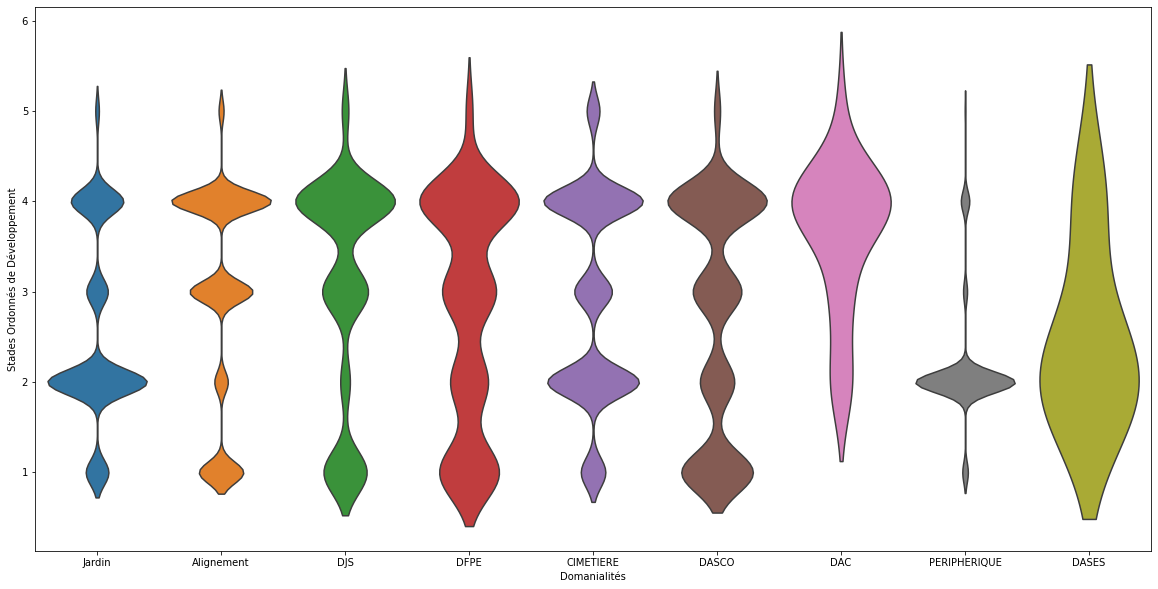

In [38]:
f = plt.figure(figsize=(20 , 10))
ax = sns.violinplot(x="Domanialités", y="Stades Ordonnés de Développement", data=data_filtre
                    .rename(columns={'sta_dev_num':'Stades Ordonnés de Développement',
                                       'domanialite': 'Domanialités'}), inner=None, scale='width')
plt.show()

### Rapport d'étude interne

[Rapport d'étude des genres d'arbres](reports_pdf/rapport.pdf) : C'est notre étude des genres d'arbres qui nous permet de voir genre par genre les informations sur les arbres.

## Automatisation de l'analyse univariée

### Analyse Multivariée par libellés français

Nous travaillons comme suit à partir des données de la ville, en choisissant un panel de quantiles de bornes superieures et inférieures [[0.8, 0.2],[0.85,0.15],[0.90,0.10],[0.95, 0.05], [0.98,0.02],[0.99,0.01]] et nous les entrons en paramètre dans l'algorithme suivant pour obtenir à chaque tour, 7 nouvelles tables avec des données qui nous permettront de faire 11 graphiques, et d'indiquer quels arbres sont en faiblesse ou en sur-dimension dans notre intervalle de confiance selon les hauteurs, et selon les circonférences.

![Analyse Univariée](analyse.png)

In [39]:
"""
q_h = 0.85
q_b = 0.15
mean = pd.DataFrame()
std = pd.DataFrame()
data_filtre_moy_qut = pd.DataFrame()
for arr in list(data_filtre['libelle_francais'].unique()):
    for age in list(data_filtre['stade_developpement'].unique()):
        mean = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].mean()
        std = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].std()  
        qut_h = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_h)  
        qut_b = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_b)  
        data_filtre_moy_qut = data_filtre_moy_qut.append({'libel':arr, 'age':age, 'quantite_var_par_age': 
                        int(data_filtre['type_emplacement'].loc[(data_filtre['libelle_francais'] == arr) &
                                                                (data_filtre['stade_developpement'] == age)].count()),                    
                        'avg_h': mean['hauteur_m'], 'std_h': std['hauteur_m'], 'qut_h_h':qut_h['hauteur_m'],'qut_h_b':qut_b['hauteur_m'],
                       'avg_c': mean['circonference_cm'], 'std_c': std['circonference_cm'], 'qut_c_h': qut_h['circonference_cm'], 'qut_c_b': qut_b['circonference_cm']}, 
                       ignore_index=True)
"""

"\nq_h = 0.85\nq_b = 0.15\nmean = pd.DataFrame()\nstd = pd.DataFrame()\ndata_filtre_moy_qut = pd.DataFrame()\nfor arr in list(data_filtre['libelle_francais'].unique()):\n    for age in list(data_filtre['stade_developpement'].unique()):\n        mean = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].mean()\n        std = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].std()  \n        qut_h = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_h)  \n        qut_b = data_filtre.loc[(data_filtre['libelle_francais'] == arr) & (data_filtre['stade_developpement'] == age)].quantile(q=q_b)  \n        data_filtre_moy_qut = data_filtre_moy_qut.append({'libel':arr, 'age':age, 'quantite_var_par_age': \n                        int(data_filtre['type_emplacement'].loc[(data_filtre['libelle_francais'] == arr) &\n               

Nous récupérons cela dans une dataframe que nous nommons data_filtre_moy_qut

In [40]:
"""
data_filtre_moy_qut = data_filtre_moy_qut.convert_dtypes()
data_filtre_moy_qut['quantite_var_par_age'] = data_filtre_moy_qut['quantite_var_par_age'].astype('int32', copy=False)
data_filtre_moy_qut.info()
"""

"\ndata_filtre_moy_qut = data_filtre_moy_qut.convert_dtypes()\ndata_filtre_moy_qut['quantite_var_par_age'] = data_filtre_moy_qut['quantite_var_par_age'].astype('int32', copy=False)\ndata_filtre_moy_qut.info()\n"

In [41]:
"""
data_filtre_moy_qut[['libel','age','quantite_var_par_age','avg_h','std_h', 'qut_h_h', 'qut_h_b','avg_c','std_c', 'qut_c_h', 'qut_c_b']].sort_values(by=['libel','age']).reset_index()
"""

"\ndata_filtre_moy_qut[['libel','age','quantite_var_par_age','avg_h','std_h', 'qut_h_h', 'qut_h_b','avg_c','std_c', 'qut_c_h', 'qut_c_b']].sort_values(by=['libel','age']).reset_index()\n"

In [42]:
data_filtre_moy_qut = pd.read_excel('data/data_filtre_moy_qut_0.95_0.05.xlsx')

Puis nous créons la table actions

In [43]:
q8 = """SELECT  data_filtre_moy_qut.libelle_francais as libelle_francais,
                    data_filtre_moy_qut.age,
                    data_filtre_moy_qut.quantite_var_par_age,
                    data_filtre_moy_qut.avg_h,
                    data_filtre_moy_qut.qut_h_h,
                    data_filtre_moy_qut.qut_h_b,
                    data_filtre_moy_qut.std_h,
                    data_filtre_moy_qut.avg_c,
                    data_filtre_moy_qut.qut_c_h,
                    data_filtre_moy_qut.qut_c_b,
                    data_filtre_moy_qut.std_c,
                    data_filtre.type_emplacement,
                    data_filtre.domanialite,
                    data_filtre.arrondissement,
                    data_filtre.complement_addresse,
                    data_filtre.lieu,
                    data_filtre.id_emplacement,
                    data_filtre.genre,
                    data_filtre.espece,
                    data_filtre.variete,
                    data_filtre.hauteur_m,
                    data_filtre.stade_developpement,
                    data_filtre.circonference_cm,
                    data_filtre.remarquable,
                    data_filtre.sta_dev_num,
                    data_filtre.geo_point_2d_a as lat,
                    data_filtre.geo_point_2d_b as lon
                FROM data_filtre 
                JOIN data_filtre_moy_qut 
                ON data_filtre_moy_qut.libelle_francais = data_filtre.libelle_francais 
                AND data_filtre.stade_developpement = data_filtre_moy_qut.age """

In [44]:
actions = ps.sqldf(q8, locals())

In [45]:
actions.libelle_francais.loc[actions['libelle_francais'] == 'Marronnier'].count()

21602

>    Dépose d'un marqueur de soin concernant la santé de l'arbre.

In [46]:
actions['sante'] = ''
actions['soin'] = ''

In [47]:
#load = actions.copy()

Le code ci-dessous est long à calculer

In [48]:
"""
for lib in list(load.libelle_francais.unique()):
    load.loc[actions['libelle_francais'] == lib, 'nb_arbre_meme_libel'] = load.libelle_francais.loc[actions['libelle_francais'] == lib].count()
for arr in list(load.arrondissement.unique()):
    load.loc[actions['arrondissement'] == arr, 'nb_arbre_meme_arr'] = load.arrondissement.loc[actions['arrondissement'] == arr].count()
for arr in list(load.arrondissement.unique()):
    for soin in ['à surveiller']:
        load.loc[actions['arrondissement'] == arr, 'nb_surv_arr'] = load.arrondissement.loc[(actions['arrondissement'] == arr) & (actions['soin'] == soin)].count()
for lieu in list(load.lieu.unique()):
    for soin in ['à surveiller']:
        load.loc[actions['lieu'] == lieu, 'nb_surv_lieu'] = load.lieu.loc[(actions['lieu'] == lieu) & (actions['soin'] == soin)].count()
"""        

"\nfor lib in list(load.libelle_francais.unique()):\n    load.loc[actions['libelle_francais'] == lib, 'nb_arbre_meme_libel'] = load.libelle_francais.loc[actions['libelle_francais'] == lib].count()\nfor arr in list(load.arrondissement.unique()):\n    load.loc[actions['arrondissement'] == arr, 'nb_arbre_meme_arr'] = load.arrondissement.loc[actions['arrondissement'] == arr].count()\nfor arr in list(load.arrondissement.unique()):\n    for soin in ['à surveiller']:\n        load.loc[actions['arrondissement'] == arr, 'nb_surv_arr'] = load.arrondissement.loc[(actions['arrondissement'] == arr) & (actions['soin'] == soin)].count()\nfor lieu in list(load.lieu.unique()):\n    for soin in ['à surveiller']:\n        load.loc[actions['lieu'] == lieu, 'nb_surv_lieu'] = load.lieu.loc[(actions['lieu'] == lieu) & (actions['soin'] == soin)].count()\n"

In [49]:
#load['nb_arbre_meme_libel'].sort_values()

In [50]:
#load['nb_arbre_meme_arr'].sort_values()

In [51]:
"""
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'sante'] = 'au-dessous'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_c'] = load['qut_c_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]
load.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_h'] = load['qut_h_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]
"""

"\nload.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'sante'] = 'au-dessous'\nload.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'soin'] = 'à surveiller'\nload.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_c'] = load['qut_c_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]\nload.loc[(load['hauteur_m'] <= load['qut_h_b'])|(load['circonference_cm'] <= load['qut_c_b']), 'value_moy_h'] = load['qut_h_b'].loc[(load['hauteur_m'] <= load['qut_h_b'])&(load['circonference_cm'] <= load['qut_c_b'])]\n"

In [52]:
"""
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'sante'] = 'au-dessus'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'soin'] = 'à surveiller'
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_c'] = load['qut_c_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_h'] = load['qut_h_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]
load['sante'].value_counts()
"""

"\nload.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'sante'] = 'au-dessus'\nload.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'soin'] = 'à surveiller'\nload.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_c'] = load['qut_c_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]\nload.loc[(load['hauteur_m'] >= load['qut_h_h'])|(load['circonference_cm'] >= load['qut_c_h']), 'value_moy_h'] = load['qut_h_h'].loc[(load['hauteur_m'] >= load['qut_h_h'])&(load['circonference_cm'] >= load['qut_c_h'])]\nload['sante'].value_counts()\n"

In [53]:
"""
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'sante'] = 'norm'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'soin'] = 'normal'
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_c'] = load['avg_c'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]
load.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))
         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_h'] = load['avg_h'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]
"""

"\nload.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))\n         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'sante'] = 'norm'\nload.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))\n         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'soin'] = 'normal'\nload.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))\n         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_c'] = load['avg_c'].loc[((load['hauteur_m'] < load['qut_h_h'])|(load['circonference_cm'] < load['qut_c_h']))]\nload.loc[((load['hauteur_m'] < load['qut_h_h'])&(load['circonference_cm'] < load['qut_c_h']))\n         &((load['hauteur_m'] > load['qut_h_b'])&(load['circonference_cm'] > load['qut_c_b'])), 'value_moy_h'] = load['avg_h'].loc[((load['hauteur_m'] < load['qut_h_h']

In [54]:
# actions = load.copy()

In [55]:
actions = pd.read_excel('data/actions_0.95_0.05.xlsx') # Fichier déjà calculé

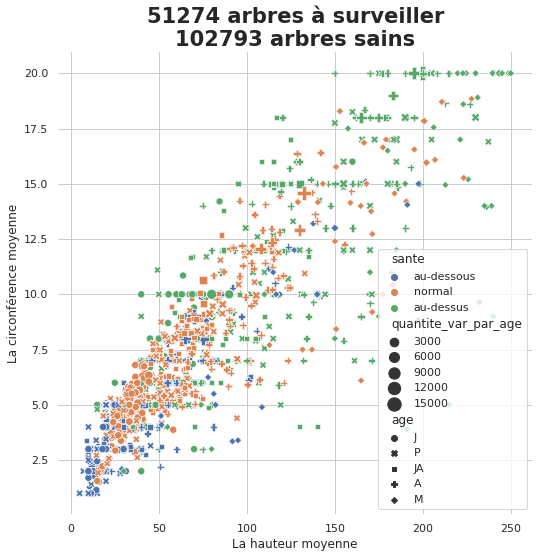

In [56]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8.5, 8.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libelle_francais'].loc[actions['soin']=='à surveiller'].count()) + ' arbres à surveiller\n' 
          +str(actions['libelle_francais'].loc[actions['soin']=='normal'].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')

sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue="sante", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']], ci="sd",ax=ax)

plt.show()

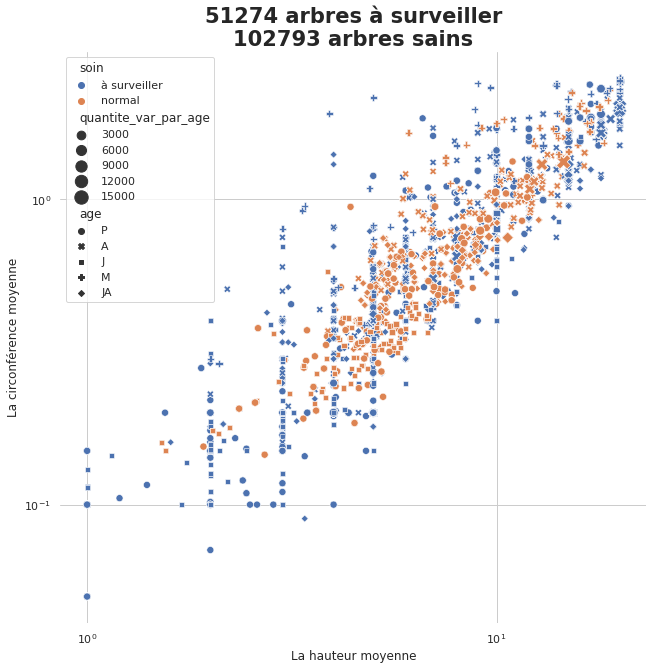

In [57]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(10.5, 10.5))
sns.despine(f, left=True, bottom=True)
plt.title(str(actions['libelle_francais'].loc[(actions['soin']=='à surveiller')].count()) + ' arbres à surveiller\n' 
          +str(actions['libelle_francais'].loc[(actions['soin']=='normal')].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Log')
plt.yscale('Log')
actions['value_moy_c_m'] = actions['value_moy_c'] / 100
sns.scatterplot(y="value_moy_c_m", x='value_moy_h',
                hue="soin",# style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age', size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c_m','age','sante','soin','quantite_var_par_age']],ax=ax)
plt.show()

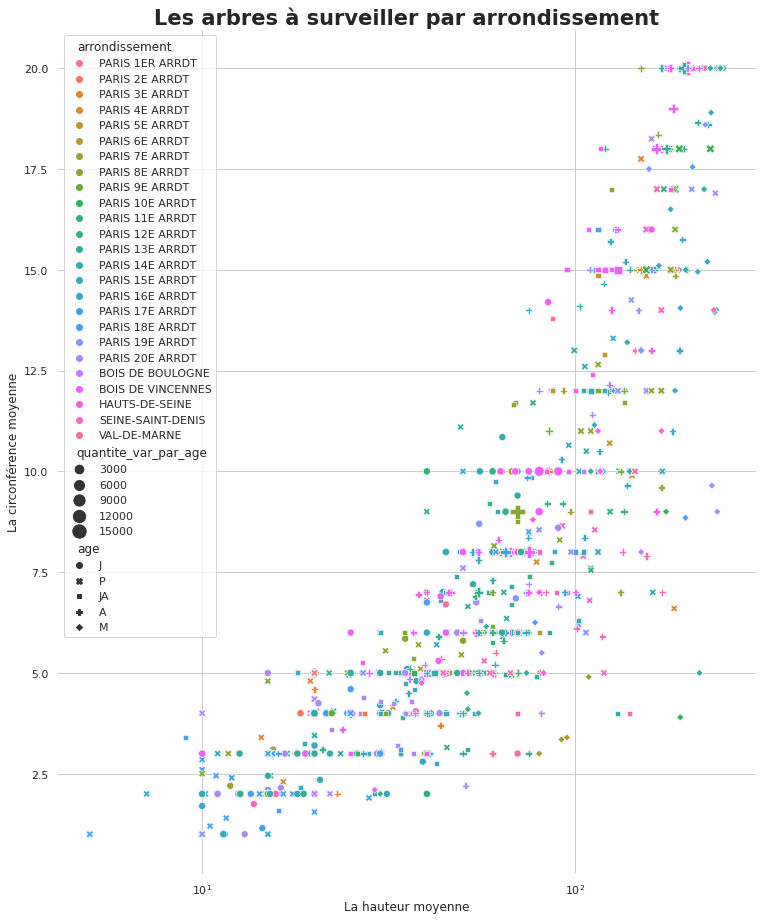

In [58]:
sns.set_theme(style="whitegrid")

arr_list = [

 'PARIS 1ER ARRDT',
 'PARIS 2E ARRDT',
 'PARIS 3E ARRDT',
 'PARIS 4E ARRDT',
 'PARIS 5E ARRDT',
 'PARIS 6E ARRDT',
 'PARIS 7E ARRDT',
 'PARIS 8E ARRDT',
 'PARIS 9E ARRDT',
 'PARIS 10E ARRDT',
 'PARIS 11E ARRDT',
 'PARIS 12E ARRDT',
 'PARIS 13E ARRDT',
 'PARIS 14E ARRDT',
 'PARIS 15E ARRDT',
 'PARIS 16E ARRDT',
 'PARIS 17E ARRDT',
 'PARIS 18E ARRDT',
 'PARIS 19E ARRDT',
 'PARIS 20E ARRDT',
 'BOIS DE BOULOGNE',
 'BOIS DE VINCENNES',
 'HAUTS-DE-SEINE',
 'SEINE-SAINT-DENIS',
 'VAL-DE-MARNE']

f, ax = plt.subplots(figsize=(12.5, 15.5))
sns.despine(f, left=True, bottom=True)
plt.title('Les arbres à surveiller par arrondissement',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Symlog')
plt.yscale('Linear')#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="value_moy_c", y='value_moy_h',
                hue_order=arr_list,
                hue="arrondissement", style_order=['J','P','JA','A','M'],
                size='quantite_var_par_age',sizes=(50, 200),
                style='age',
                 size_order=(actions['nb_arbre_meme_libel'].min(),actions['nb_arbre_meme_libel'].min()),
                data=actions[['value_moy_h','arrondissement','value_moy_c','age','sante','soin','quantite_var_par_age']].loc[actions['soin']=='à surveiller'], ci='sd',ax=ax)
plt.show()

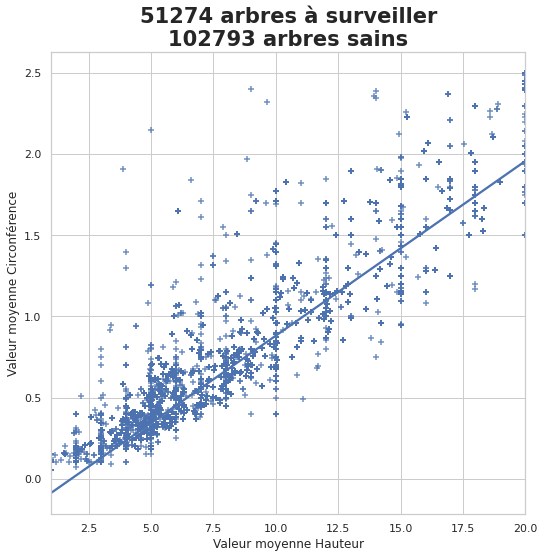

In [59]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8.5, 8.5))
plt.title(str(actions['libelle_francais'].loc[(actions['soin']=='à surveiller')].count()) + ' arbres à surveiller\n' 
          +str(actions['libelle_francais'].loc[(actions['soin']=='normal')].count()) + ' arbres sains',
          fontdict={'fontsize':21, 'fontweight': 'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.xscale('Linear')
plt.yscale('Linear')
actions['value_moy_c_m'] = actions['value_moy_c'] / 100
sns.regplot( y="Valeur moyenne Circonférence", x="Valeur moyenne Hauteur",fit_reg=True,marker='+',
            data=actions[['value_moy_h','arrondissement','value_moy_c_m','age','sante','soin','quantite_var_par_age']].rename(columns={'value_moy_h':'Valeur moyenne Hauteur','value_moy_c_m': "Valeur moyenne Circonférence"}))
plt.show()



### Analyse du nombre d'arbre par arrondissement.

Nous réalisons des jointures complexes de tables pour aggréger des données relatives aux lieux, aux arrondissements picspicsainsi qu'aux quantités d'arbres.

In [60]:
data_end = pd.read_excel('data/new_data_end_0.95_0.05.xlsx') # Nous avons calculer cette table au préalable

In [61]:
q9 = """SELECT data_end.arrondissement as arr, 
                COUNT(*) as total
                FROM data_end
               GROUP BY data_end.arrondissement
"""

In [62]:
actions_hist = ps.sqldf(q9, locals())

In [63]:
q10 = """SELECT data_end.arrondissement as arr, 
                COUNT(soin) as surveiller
                FROM data_end WHERE soin LIKE '%surveiller'
               GROUP BY data_end.arrondissement
"""

In [64]:
actions_hist_soin = ps.sqldf(q10, locals())

In [65]:
qa10 = """SELECT data_end.arrondissement as arr, 
                COUNT(soin) as verifier
                FROM data_end WHERE soin LIKE '%vérifier'
                   GROUP BY data_end.arrondissement
"""

In [66]:
data_end['soin'].value_counts()

normal          102793
à surveiller     51274
à vérifier       46070
Name: soin, dtype: int64

In [67]:
actions_hist_verif = ps.sqldf(qa10, locals())

In [68]:
q11 = """SELECT actions_hist.arr as arr, 
                actions_hist.total,
                actions_hist_soin.surveiller,
                actions_hist_verif.verifier
                FROM actions_hist JOIN actions_hist_soin, actions_hist_verif
                ON actions_hist.arr = actions_hist_soin.arr AND
                actions_hist.arr = actions_hist_verif.arr
"""

In [69]:

actions_hist_merge = ps.sqldf(q11, locals())

In [70]:
actions_hist_merge

,arr,total,surveiller,verifier
0,BOIS DE BOULOGNE,3978,883,769
1,BOIS DE VINCENNES,11510,3244,4224
2,HAUTS-DE-SEINE,5298,399,4408
3,PARIS 10E ARRDT,3385,984,489
4,PARIS 11E ARRDT,5658,2060,265
5,PARIS 12E ARRDT,12600,4207,809
6,PARIS 13E ARRDT,16712,4573,3365
7,PARIS 14E ARRDT,11399,3276,391
8,PARIS 15E ARRDT,17151,3170,5832
9,PARIS 16E ARRDT,16403,4092,2035


In [71]:
data_hist_chart = actions_hist_merge.copy()

In [72]:
data_hist_chart.sum()

arr           BOIS DE BOULOGNEBOIS DE VINCENNESHAUTS-DE-SEIN...
total                                                    200137
surveiller                                                51274
verifier                                                  46070
dtype: object

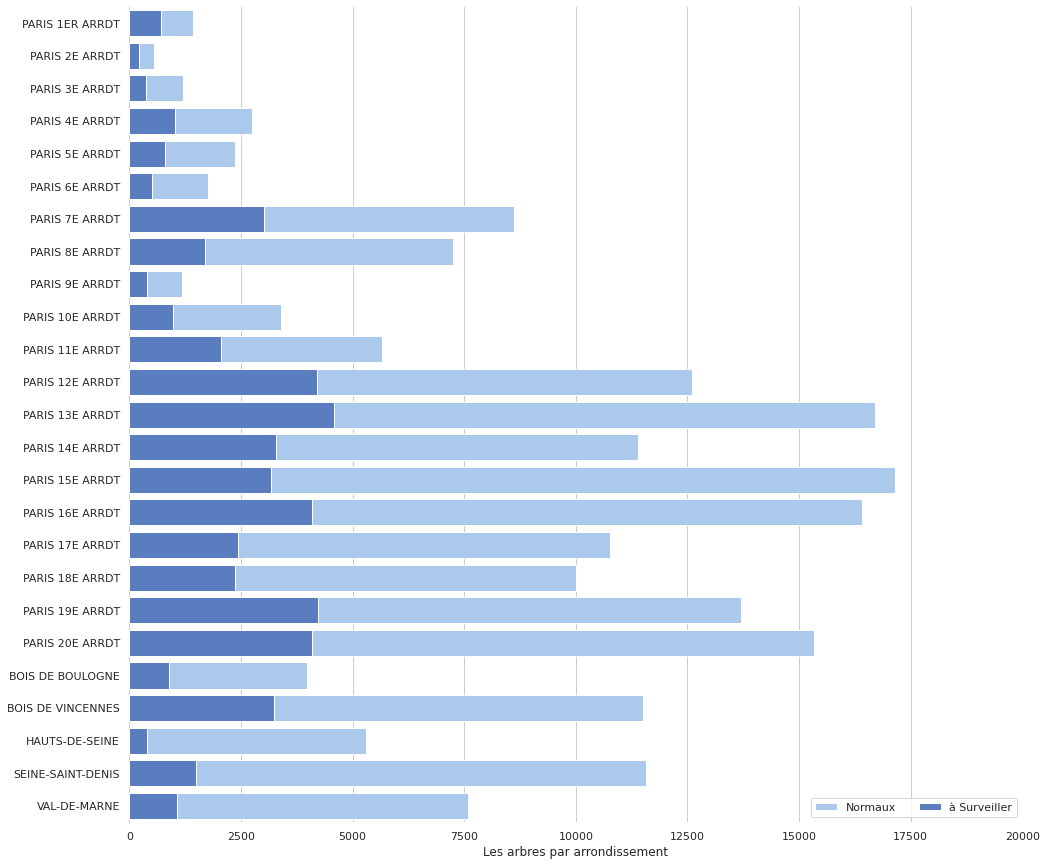

In [73]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 15))

# Load the example car crash dataset
crashes = data_hist_chart

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(order=arr_list,x="total", y="arr", data=crashes,
            label="Normaux", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(order=arr_list,x="surveiller", y="arr", data=crashes,
            label="à Surveiller", color="b")

# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(xlim=(0, 20000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
plt.show()

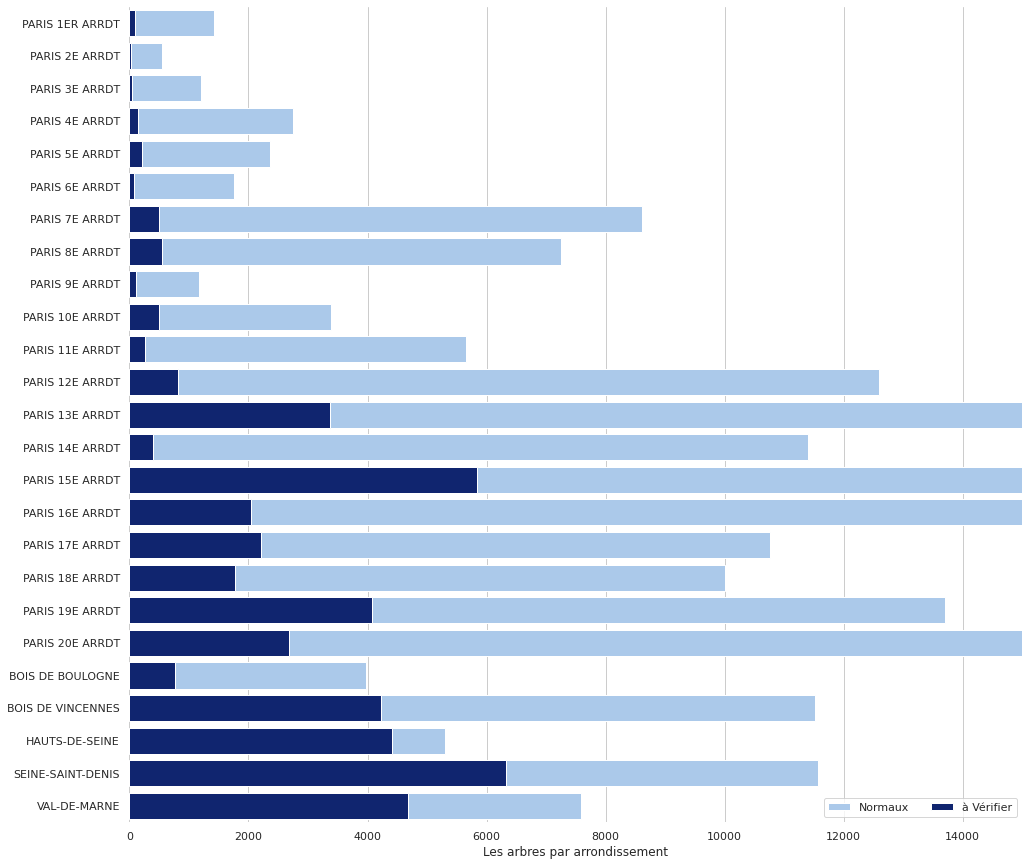

In [74]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 15))

# Load the example car crash dataset
crashes = data_hist_chart
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(order=arr_list,x="total", y="arr", data=crashes,
            label="Normaux", color="b")

# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
#sns.barplot(order=arr_list,x="surveiller", y="arr", data=crashes,
#            label="à Surveiller", color="b")

sns.set_color_codes("dark")
sns.barplot(order=arr_list,x="verifier", y="arr", data=crashes,
            label="à Vérifier", color="b")


# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(xlim=(0, 15000), ylabel="",
       xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)
plt.show()

#### Analyse du nombre d'arbre par arrondissement et par stade de développement.

In [75]:
qa9 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.arrondissement, actions.age
"""

In [76]:
actions_hist_stadev = ps.sqldf(qa9, locals())

In [77]:
qa10 = """SELECT actions.arrondissement as arr, 
                actions.age,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.arrondissement, actions.age
"""

In [78]:
actions_hist_stadev_soin = ps.sqldf(qa10, locals())

In [79]:
qa11 = """SELECT actions_hist_stadev.arr as arr, 
                actions_hist_stadev.age,
                actions_hist_stadev.total,
                actions_hist_stadev_soin.surveiller 
                FROM actions_hist_stadev JOIN actions_hist_stadev_soin ON actions_hist_stadev.arr = actions_hist_stadev_soin.arr AND
                actions_hist_stadev.age = actions_hist_stadev_soin.age

"""


In [80]:

actions_hist_stadev_merge = ps.sqldf(qa11, locals())

In [81]:
actions_hist_stadev_merge

,arr,age,total,surveiller
0,BOIS DE BOULOGNE,A,1202,267
1,BOIS DE BOULOGNE,J,667,203
2,BOIS DE BOULOGNE,JA,1136,234
3,BOIS DE BOULOGNE,P,193,179
4,BOIS DE VINCENNES,A,2716,1003
...,...,...,...,...
119,VAL-DE-MARNE,A,1370,475
120,VAL-DE-MARNE,J,360,103
121,VAL-DE-MARNE,JA,646,150
122,VAL-DE-MARNE,M,153,108


In [82]:
data_hist__stdev_chart = actions_hist_stadev_merge.copy()

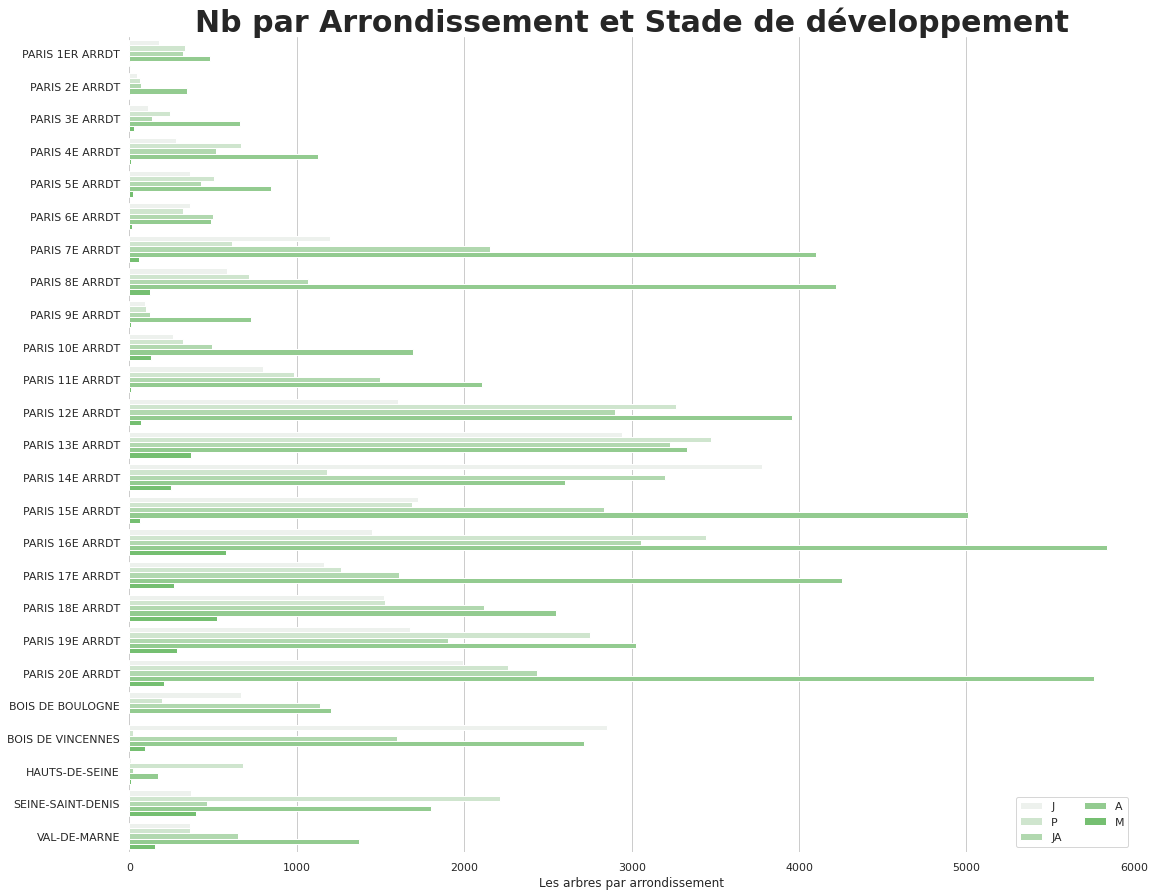

In [83]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Load the example car crash dataset
crashes = data_hist__stdev_chart
# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(order=arr_list, hue_order=['J','P','JA','A','M'],x="total", y="arr", hue="age", data=crashes,
             color="g")
plt.title('Nb par Arrondissement et Stade de développement', fontdict={'fontsize':30, 'fontweight':'bold'})
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 6000), ylabel="",xlabel="Les arbres par arrondissement")
sns_plot = sns.despine(left=True, bottom=True)



### Analyse des arbres les plus fréquents par arrondissement

In [84]:
freq_libel_arr = actions[['arrondissement', 'libelle_francais','nb_arbre_meme_libel_arr']].copy()

In [85]:
freq_libel_arr = freq_libel_arr[~freq_libel_arr.duplicated()].sort_values(by='arrondissement')

In [86]:
freq = pd.DataFrame()
for arr in list(freq_libel_arr['arrondissement'].unique()):
    freq =freq.append(freq_libel_arr.loc[freq_libel_arr['arrondissement'] == arr].sort_values(by='nb_arbre_meme_libel_arr').iloc[-5:])

In [87]:
freq_libel_arr.rename(columns={'libel':'libelle_francais'}).to_excel('data_freq_libel_arr.xlsx')

In [88]:
freq

,arrondissement,libelle_francais,nb_arbre_meme_libel_arr
51249,BOIS DE BOULOGNE,Tilleul,379
50372,BOIS DE BOULOGNE,Erable,390
54304,BOIS DE BOULOGNE,Platane,416
49406,BOIS DE BOULOGNE,Noisetier de Byzance,548
51780,BOIS DE BOULOGNE,Marronnier,1101
...,...,...,...
30432,VAL-DE-MARNE,Cerisier à fleurs,173
19019,VAL-DE-MARNE,Tilleul,198
19033,VAL-DE-MARNE,Peuplier,254
19526,VAL-DE-MARNE,Platane,294


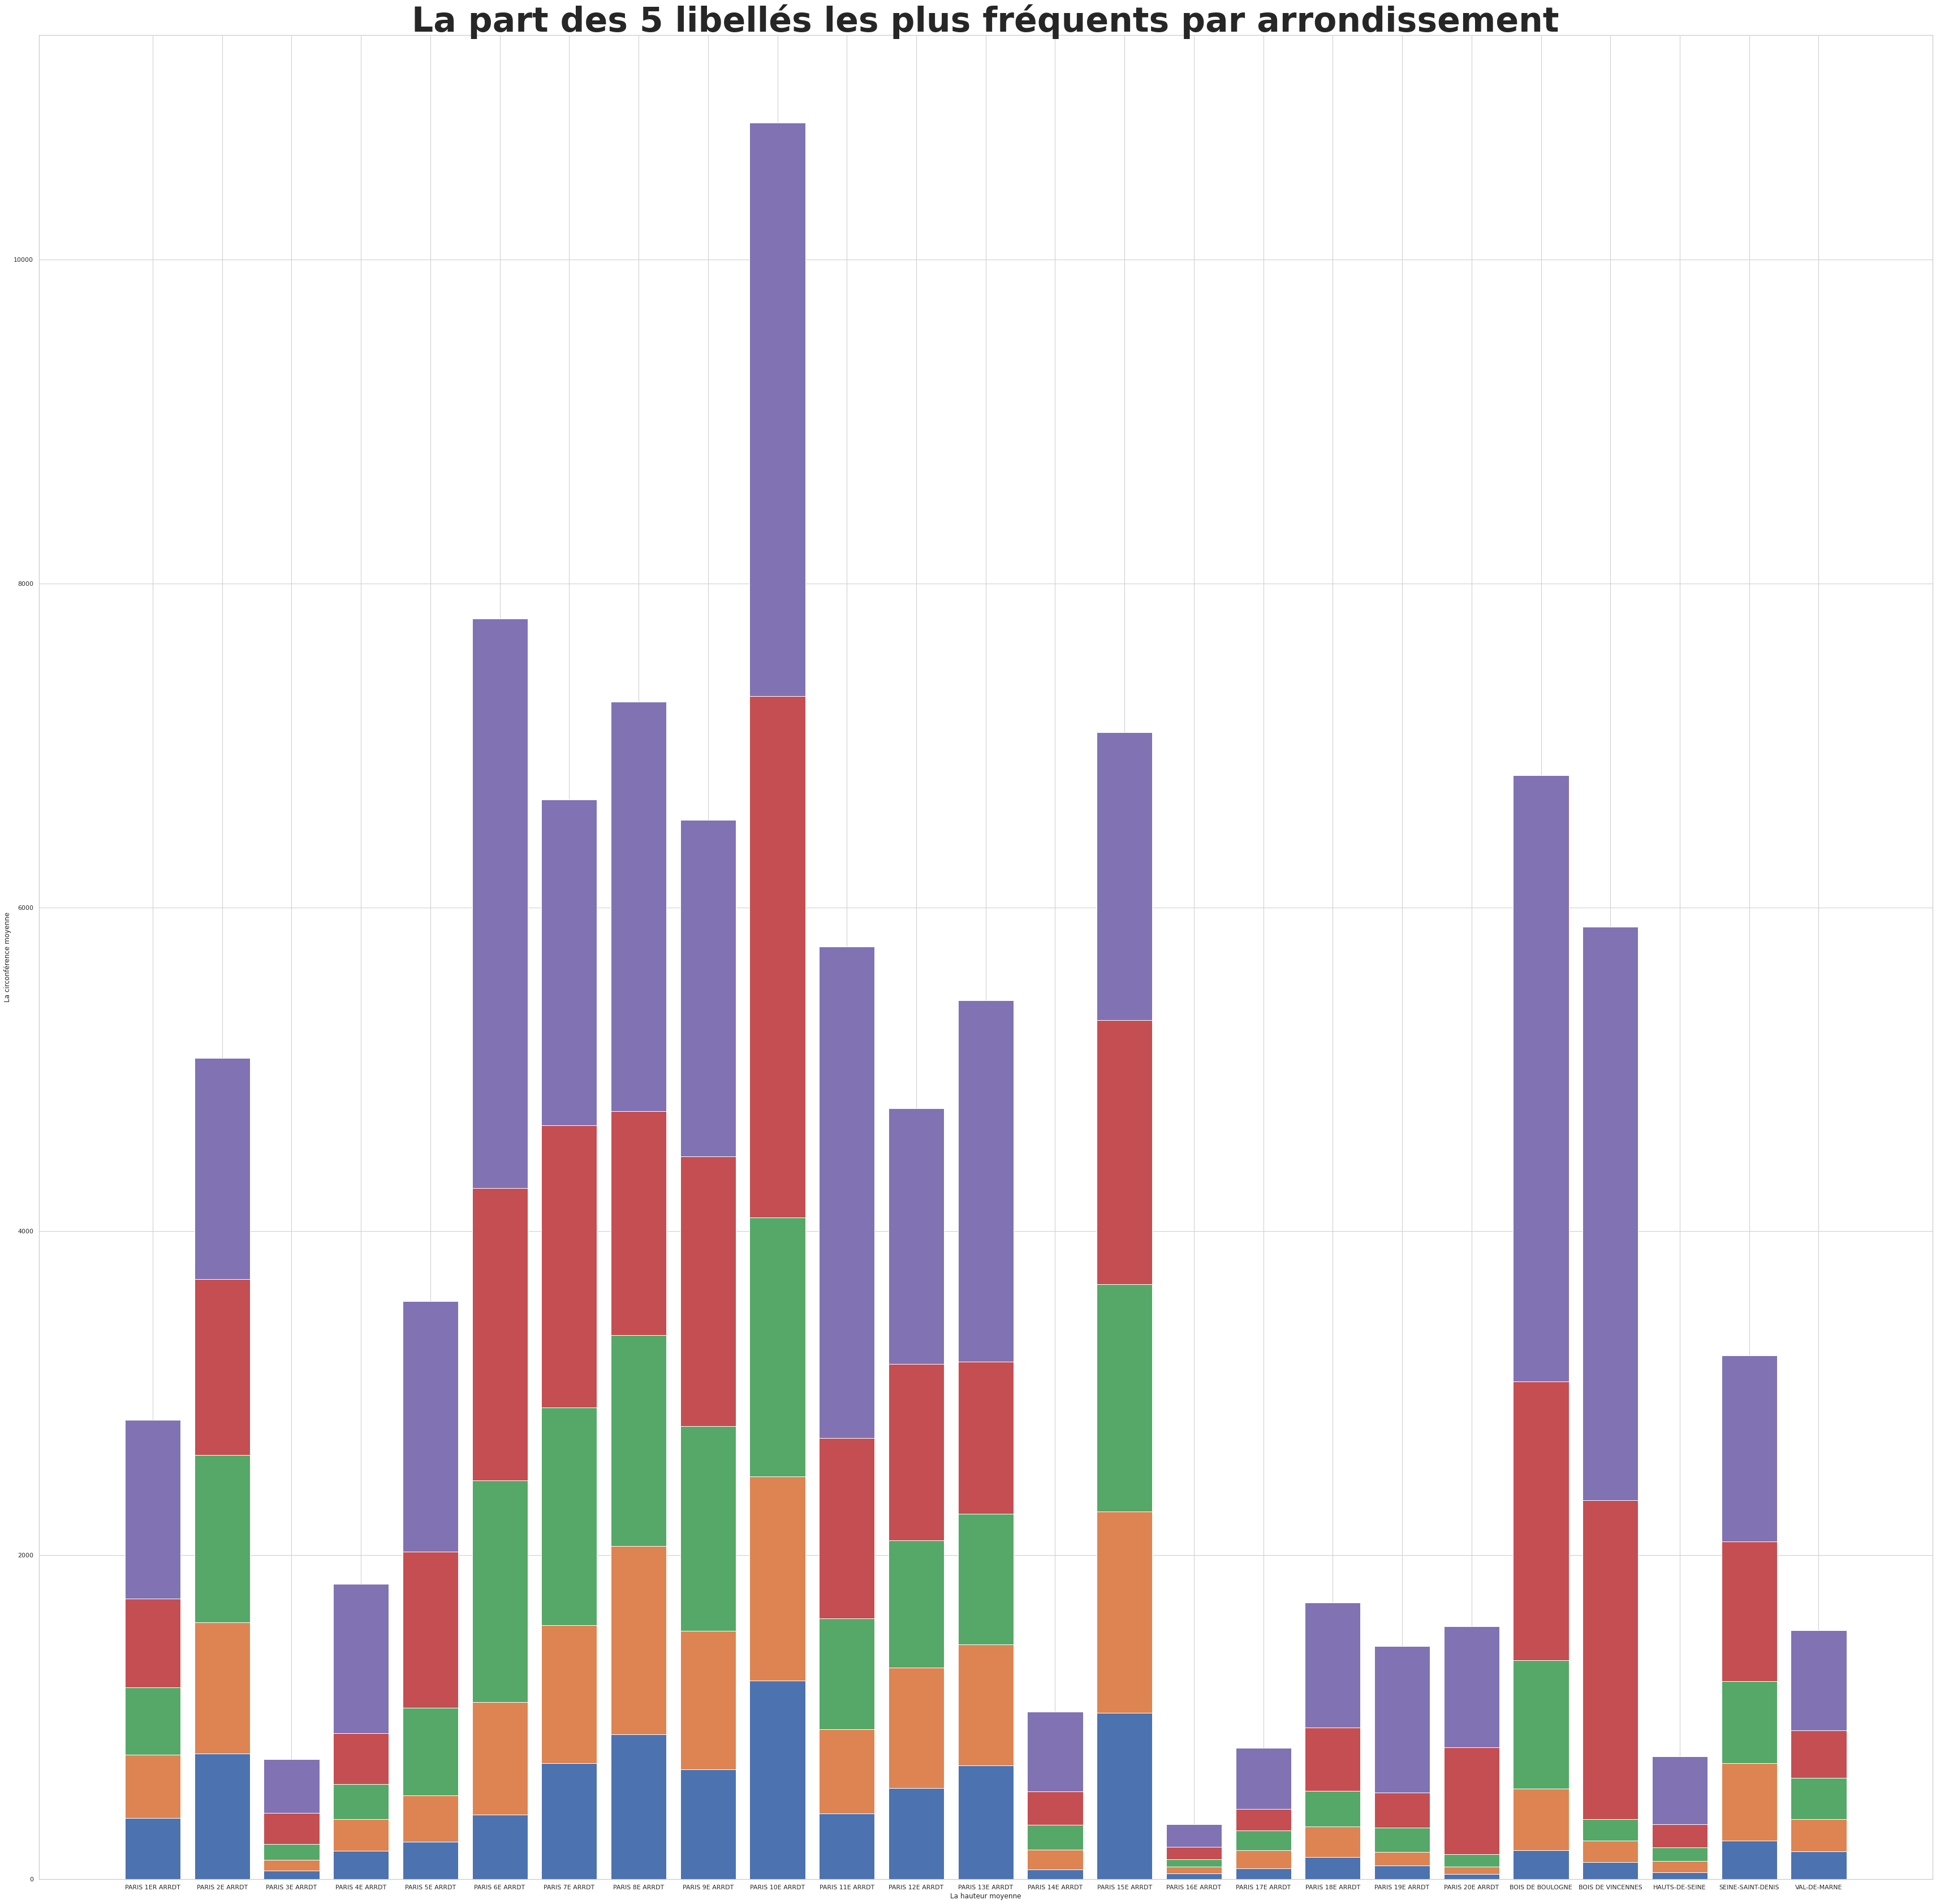

In [89]:
f, ax = plt.subplots(figsize=(60, 60))
A = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[0::5]))
B = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[1::5]))
C = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[2::5]))
D = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[3::5]))
E = np.array(list(freq['nb_arbre_meme_libel_arr'].iloc[4::5]))
Pos = range(25)
plt.bar(Pos, A)
plt.bar(Pos, B, bottom = A)
plt.bar(Pos, C, bottom = A + B)
plt.bar(Pos, D, bottom = A + B + C)
plt.bar(Pos, E, bottom = A + B + C + D)
plt.xticks(Pos, arr_list)
plt.title('La part des 5 libellés les plus fréquents par arrondissement', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.ylabel('La circonférence moyenne')
plt.xlabel('La hauteur moyenne')
plt.show() 

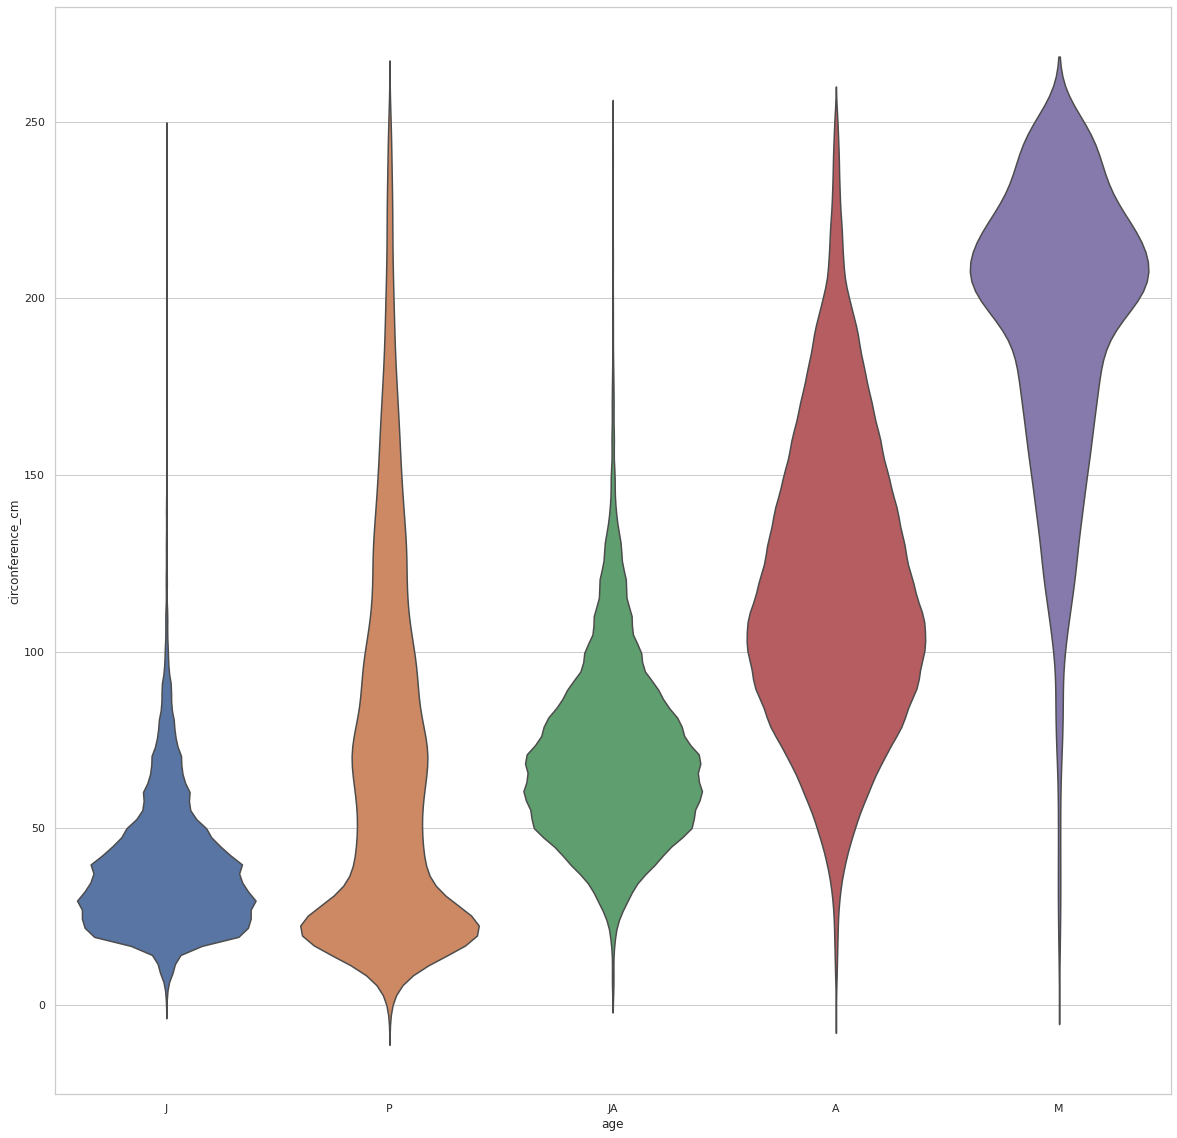

In [90]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="circonference_cm", data=actions, inner=None, scale='width')


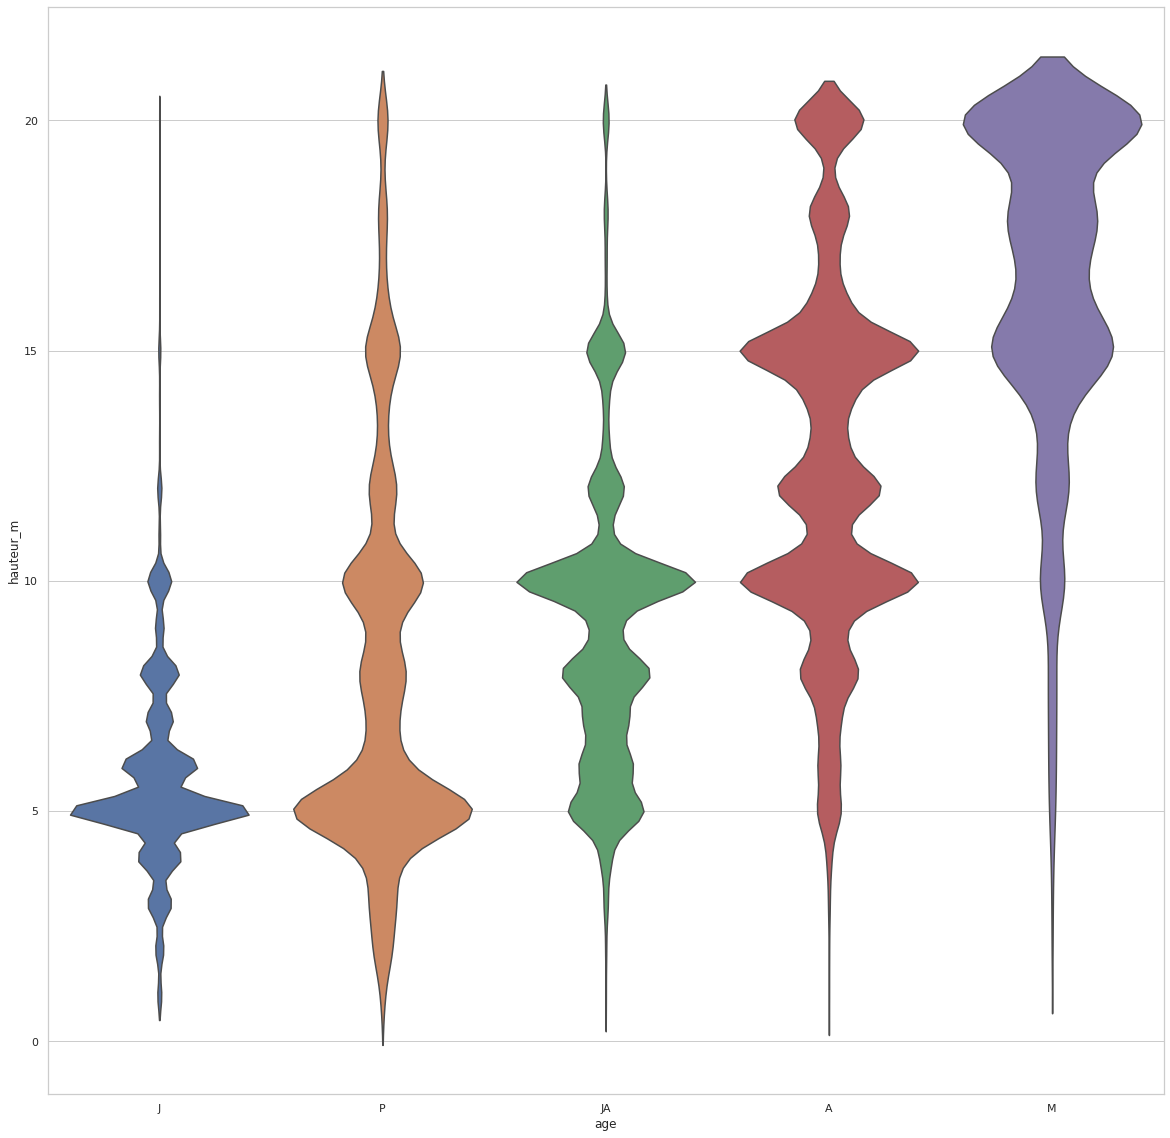

In [91]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(order=['J','P','JA','A','M'],x="age", y="hauteur_m", data=actions, inner=None, scale='width')

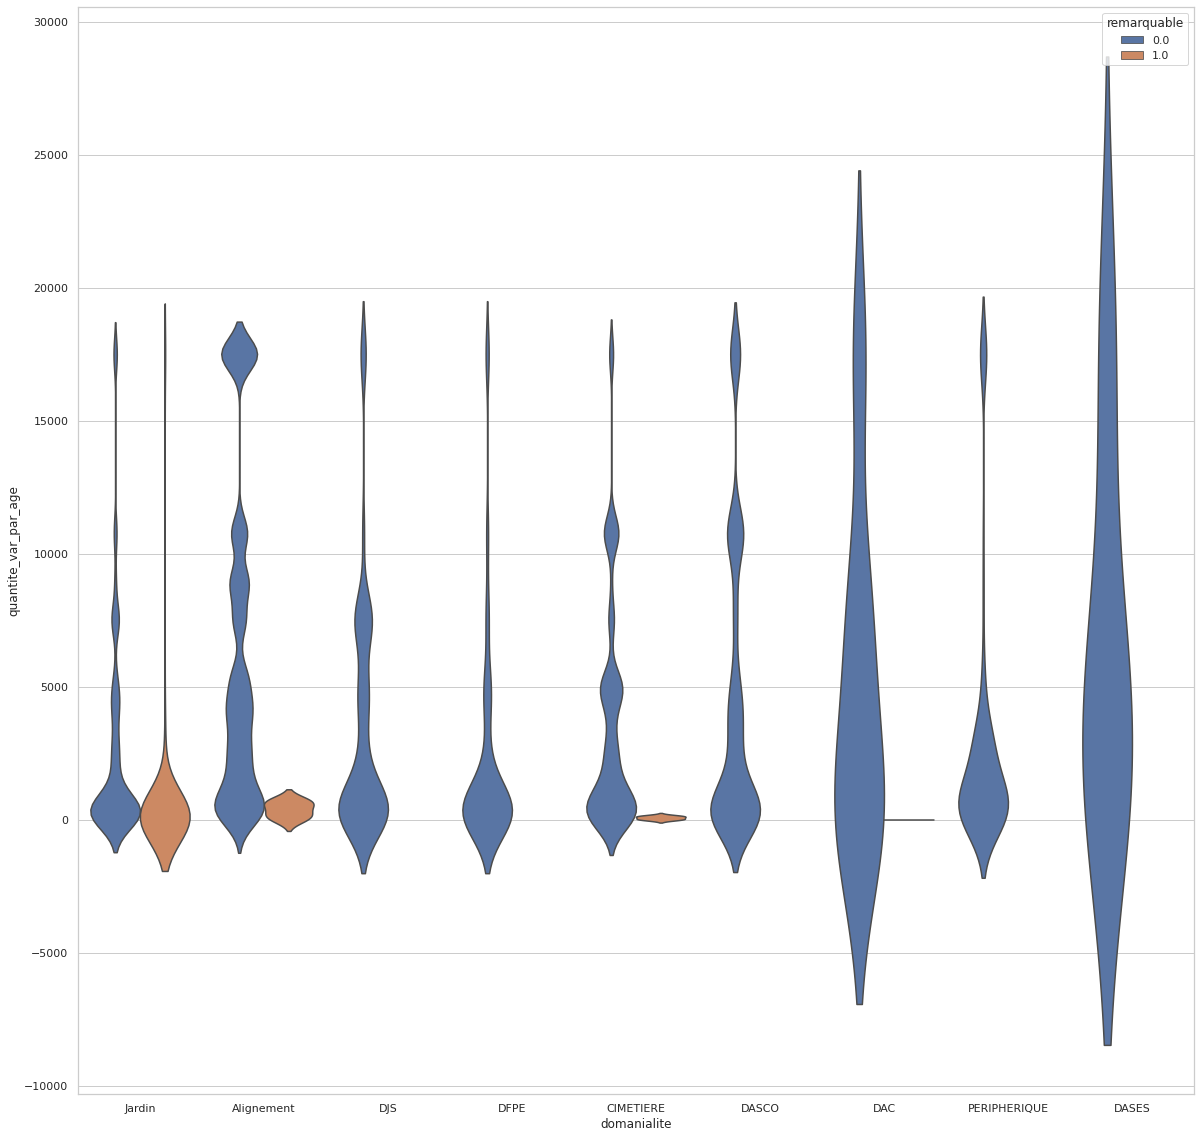

In [92]:
f = plt.figure(figsize=(20 , 20))
ax = sns.violinplot(x="domanialite",hue="remarquable", y="quantite_var_par_age", data=actions, inner=None, scale='width')

In [93]:
q12 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(*) as total
                FROM actions
       GROUP BY actions.lieu
"""

In [94]:
actions_hist_lieu = ps.sqldf(q12, locals())

In [95]:
actions_hist_lieu.loc[actions_hist_lieu['lieu']== 'JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH']

,lieu,arrondissement,total
2908,JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,PARIS 16E ARRDT,601


In [96]:
q13 = """SELECT actions.lieu as lieu, 
                actions.arrondissement,
                COUNT(soin) as surveiller
                FROM actions WHERE soin LIKE '%surveiller'
       GROUP BY actions.lieu
"""

In [97]:
actions_hist_lieu_soin = ps.sqldf(q13, locals())

In [98]:
actions_hist_lieu_soin

,lieu,arrondissement,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1
3,AFFRE (9),PARIS 18E ARRDT,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,5
...,...,...,...
4216,VOSGES (12) MAT,PARIS 4E ARRDT,3
4217,VULPIAN (13) ELEM,PARIS 13E ARRDT,2
4218,WATTIGNIES (52) ELEM,PARIS 12E ARRDT,1
4219,WURTZ (16) ELEM,PARIS 13E ARRDT,2


In [99]:
q14 = """SELECT actions_hist_lieu_soin.lieu as lieu, 
                actions_hist_lieu.arrondissement,
                actions_hist_lieu.total,
                actions_hist_lieu_soin.surveiller 
                FROM actions_hist_lieu JOIN actions_hist_lieu_soin ON actions_hist_lieu.lieu = actions_hist_lieu_soin.lieu


"""


In [100]:

actions_hist_lieu_merge = ps.sqldf(q14, locals())

In [101]:
actions_hist_lieu_merge

,lieu,arrondissement,total,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,3,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1,1
3,AFFRE (9),PARIS 18E ARRDT,2,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,22,5
...,...,...,...,...
4216,VOSGES (12) MAT,PARIS 4E ARRDT,7,3
4217,VULPIAN (13) ELEM,PARIS 13E ARRDT,11,2
4218,WATTIGNIES (52) ELEM,PARIS 12E ARRDT,7,1
4219,WURTZ (16) ELEM,PARIS 13E ARRDT,13,2


Text(0, 0.5, 'arbres à surveiller')

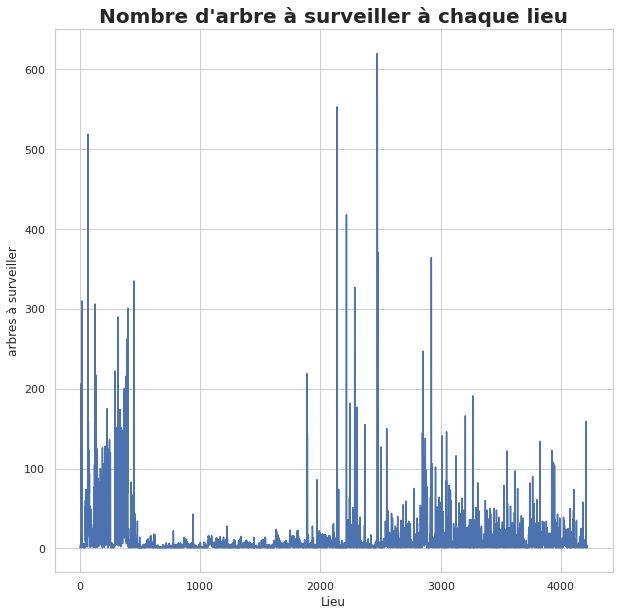

In [102]:
f = plt.figure(figsize=(10 , 10))
ax = actions_hist_lieu_merge['surveiller'].plot()
plt.title('Nombre d\'arbre à surveiller à chaque lieu', fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel('Lieu')
plt.ylabel('arbres à surveiller')



In [103]:
chemin_note = pd.read_pickle('data/chemin_0.95_0.05.dat')

In [104]:
road_dict_df = dict()
for i in arr_list:
    road_dict_df.update({i:chemin_note['road'][i]})

In [105]:
road_df = pd.DataFrame.from_dict(road_dict_df, orient='index')

In [106]:
road_df.transpose().to_excel('chemin_par_arrondissement.xlsx')

In [107]:
actions_simple = actions.rename(columns={'lat':'geo_point_2d_a', 'lon':'geo_point_2d_b'})

In [108]:
action_df_simple = actions_simple[['type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais',
       'genre', 'espece', 'variete', 'circonference_cm', 'hauteur_m',
       'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b', 'soin']].copy()

In [109]:
action_df_simple.count()

type_emplacement       154067
domanialite            154067
arrondissement         154067
complement_addresse     29870
lieu                   154067
id_emplacement         154067
libelle_francais       154067
genre                  154067
espece                 154067
variete                154067
circonference_cm       154067
hauteur_m              154067
stade_developpement    154067
remarquable            122591
geo_point_2d_a         154067
geo_point_2d_b         154067
soin                   154067
dtype: int64

In [110]:
data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].count()

type_emplacement       46070
domanialite            46070
arrondissement         46070
complement_addresse    46070
numero                     0
lieu                   46070
id_emplacement         46070
libelle_francais       46070
genre                  46070
espece                 46070
variete                46070
circonference_cm       46070
hauteur_m              46070
stade_developpement    46070
remarquable            14448
geo_point_2d_a         46070
geo_point_2d_b         46070
sta_dev_num            46070
dtype: int64

In [111]:
data_new = data.loc[((data["hauteur_m"] >= 21) | (data["hauteur_m"] <= 0)) \
                          | ((data["circonference_cm"] >= 255) | (data["circonference_cm"] <= 0))].copy()

In [112]:
data_new['soin'] = 'à vérifier'

In [113]:
data_end = action_df_simple.append(data_new).copy()

In [114]:
data_end = data_end.drop(['sta_dev_num'], axis=1)

In [115]:
actions_simple['soin'].value_counts()

normal          102793
à surveiller     51274
Name: soin, dtype: int64

## Partie Algorithmie, Optimisation des trajets

À présent, nous allons tâcher de répondre à la problématique du meilleur trajet, qui est un problème similaire au problème du voyageur de commerce pour lequel nous souhaitons utiliser l'algorithme de [Christofides](https://fr.wikipedia.org/wiki/Algorithme_de_Christofides). Pour cela nous utiliserons un GPU en local, pour calculer les distances entre tous les lieux, et nous lancerons l'algorithme de recherche du plus court chemin entre tous les lieux soit $6921$ éléments distincts.

Nous devons suivre le schéma suivant pour construire l'algorithme de Christofides :



![Algorithme de Christofides](algorithme.png)

## Calcul du meilleur trajet

### Calcul des distances entre chaque lieu

Nous relevons 200137 points d'intérêts sur la table. Nous utilisons les données géosphérique pour les représenter dans un espace de Riemann.

Nous utilisons ensuite une représentation en graphe pour utiliser la solution de Christofides dans notre code en programmation orientée objet avec Python

1. Nous calculons les longueurs des permutations entre 2 points en gardant toujours le plus court. Ainsi la solution de Christofides est au pire 1.5 fois plus long que le chemin le plus court.

![Algorithme de Christofides](christofides_plan.png)

In [116]:
df = data[['arrondissement', 'lieu', 'geo_point_2d_a', 'geo_point_2d_b', 'genre']].copy()

**Nous éliminons ainsi les lieux doublons**, notons que les bulles de circonférences sont en rapport avec le nombre de ligne (et donc d'arbre) disparaissant dans cette opération.

In [117]:
df = df.drop_duplicates(subset='lieu', ignore_index=True)

In [120]:
q7 = """SELECT  df.lieu as lieu,
                df.arrondissement as arrond,
                df.geo_point_2d_a as lat,
                df.geo_point_2d_b as lon
                FROM df """

In [121]:
df_graph = ps.sqldf(q7, locals())

In [122]:
df_graph

,lieu,arrond,lat,lon
0,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,PARIS 7E ARRDT,48.857620,2.320962
1,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,PARIS 17E ARRDT,48.890435,2.315289
2,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,PARIS 16E ARRDT,48.876722,2.280222
3,JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,PARIS 16E ARRDT,48.871990,2.275814
4,JARDIN DU RANELAGH,PARIS 16E ARRDT,48.858222,2.269287
...,...,...,...,...
6916,TALUS DE LA RUE FRANC NOHAIN / 5 RUE FRANC NOHAIN,PARIS 13E ARRDT,48.821062,2.375242
6917,TALUS N°27-02,PARIS 19E ARRDT,48.879833,2.407820
6918,TERRAIN D EDUCATION PHYSIQUE / 49 RUE OLIVIER ...,PARIS 20E ARRDT,48.873912,2.393115
6919,RUE EDOUARD QUENU,PARIS 5E ARRDT,48.839162,2.349511


Nous exportons notre tableau trier par ordre alphabétique de lieu pour l'utiliser sur notre gpu et pour que nous réalisions le calcul de la matrice heuristique des distances entre les lieux.

2. Nous calculerons la matrices des distances entre chaque lieu sur un gpu (le code est fourni en annexe), et ce sera donc une matrice de (6921 x 6921). Une distance est donnée par la relation $\sqrt{((x_1 - x_0)*111)^2 + ((y_1 - y_0)*80)^2} ,\forall x \in latitude, \forall  y\in longitude$ en France, pour la distance en $km$. Le script de calcul de cette matrice est réalisé dans l'IDE PyCharm avec la bibliothèque PyCuda et une carte NVIDIA, localement. L'écriture du code en C ne se prête hélas pas tellement, visuellement parlant, au Notebook de Jupyter.

En sortie nous traitons notre matrice pour la retrouver dans une dataframe avec nos indexes et colonnes en nom de lieu. Comme les calculs ont été réalisés dans des "numpy arrays" les colonnes n'ont pas été nommées. Mais nous avons effectuer les calculs sur un échantillon des données avec notre cpu, puis nous importerons le fichier de résultats de 600Mo dans une DataFrame pour les comparer et voir que nous trouvons le même résultat sur un échantillon.

In [123]:
distances_cpu = pd.DataFrame(df_graph, index=df_graph['lieu'].unique(), columns=df_graph['lieu'].unique())

In [124]:
for it, row in enumerate(distances_cpu.iloc[:5,:5].columns):
    for it, col in enumerate(distances_cpu.iloc[:5,:5].columns):
        distances_cpu[col].loc[row] = math.sqrt(((df_graph['lat'].loc[df_graph['lieu'] == col].values - df_graph['lat'].loc[df_graph['lieu'] == row].values)*111)**2\
+ ((df_graph['lon'].loc[df_graph['lieu'] == col].values - df_graph['lon'].loc[df_graph['lieu'] == row].values)*80)**2)

distances_cpu.iloc[:5,:5]

,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE LA PORTE MAILLOT,JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,JARDIN DU RANELAGH
MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,0.000000,3.670663,3.888225,3.948374,4.134577
PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,3.670663,0.000000,3.191785,3.763651,5.131259
SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE LA PORTE MAILLOT,3.888225,3.191785,0.000000,0.632604,2.232088
JARDIN DE L AVENUE FOCH / 10 AVENUE FOCH,3.948374,3.763651,0.632604,0.000000,1.615048
JARDIN DU RANELAGH,4.134577,5.131259,2.232088,1.615048,0.000000


Comme l'algorithme que nous avons développé à partir du schéma proposé par Christofides est de complexité Quadratique, $O(x) = x^2$, nous exportons les calculs sur notre Gpu, localement, mais cela reste déconseillé sur un cpu à cause du temps de calcul.

### Optimisation des trajets

In [125]:
import christofides

christofides.christofides()

Pour l'arrondissement PARIS 1ER ARRDT : 

Au départ le chemin de poids mininum est :  9.413039626863458
Nombre de kilomètre par Christofides : 6km
Chemin de départ : ['AVENUE VICTORIA', 'JARDINIERES ANGLE RUE DE RIVOLI - RUE DES HALLES / 1 RUE DES HALLES', 'RUE SAINT DENIS', 'PLACE DU CHATELET', 'RUE DES HALLES', 'RUE DES LOMBARDS', 'JARDINIERE DE LA PLACE SAINTE OPPORTUNE / 2 PLACE SAINT OPPORTUNE', 'RUE DU PLAT D ETAIN', 'RUE DE LA FERRONNERIE', 'RUE DES INNOCENTS', 'RUE DE LA REYNIE', 'PLACE JOACHIM DU BELLAY', 'RUE DE LA COSSONNERIE', 'RUE DE TURBIGO', 'RUE PIERRE LESCOT', 'RUE DE LA GRANDE TRUANDERIE', 'RUE RAMBUTEAU', 'JARDINIERE DE LA RUE MAUCONSEIL / 31 RUE MAUCON MAUCONSEIL', 'RUE JEAN JACQUES ROUSSEAU', 'RUE COQUILLIERE', 'RUE COQ HERON', 'PLACE DES DEUX ECUS', 'RUE BERGER', 'JARDINS DES HALLES', 'ECOLE ELEMENTAIRE / 15 RUE ARBRE SEC', 'QUAI DU LOUVRE', 'PLACE DU LOUVRE', 'SQUARE MICHEL CALDAGUES / 1V PLACE DU LOUVRE', 'PORT DU LOUVRE', 'SQUARE DU VERT GALANT / 4W PLACE DU PO

Nombre de kilomètre par Christofides : 9km
Chemin de départ : ['BOULEVARD DU MONTPARNASSE', 'LITTRE (6) MAT', 'LITTRE (2 ET 4)', 'LITTRE (6) ELEM', 'PLACE DU DIX HUIT JUIN 1940', "SQUARE DE L'EGLISE NOTRE DAME DES CHAMPS", 'PLACE PIERRE LAFUE', 'SQUARE OZANAM', 'RUE BREA', 'RUE D ASSAS', "PROMENADE DE L'ALLEE DU SEMINAIRE", 'RUE GUYNEMER', 'RUE BONAPARTE', 'MADAME (42) ELEM', 'PLACE SAINT SULPICE', 'JARDINIERE MAIRIE DU 6EME', 'MADAME (5) LYCEE MUNICIPAL', 'RUE CASSETTE', 'PLACE ALPHONSE DEVILLE', 'CARREFOUR CROIX ROUGE', 'RUE SAINT PLACIDE', 'RUE DE RENNES', 'RUE AUGUSTE COMTE', 'ESPLANADE GASTON MONNERVILLE', 'PLACE ERNEST DENIS', 'PLACE EDMOND ROSTAND', 'JARDIN DES GRANDS EXPLORATEURS', 'PLACE CAMILLE JULLIAN', 'RUE DE MEDICIS', 'SQUARE FRANCIS POULENC', 'RUE SAINT SULPICE', 'RUE CREBILLON', 'CARREFOUR ODEON', 'PLACE HENRI MONDOR', 'BOULEVARD SAINT MICHEL', 'BOULEVARD SAINT GERMAIN', 'PLACE SAINT ANDRE DES ARTS', 'QUAI DES GRANDS AUGUSTINS', 'SQUARE GABRIEL PIERNE', 'QUAI DE CONTI',

Au départ le chemin de poids mininum est :  46.85864911276657
Nombre de kilomètre par Christofides : 31km
Chemin de départ : ['ALLEE VIVALDI', 'RUE ANTOINE JULIEN HENARD', 'JARDIN DE REUILLY', 'RUE ALBINONI', 'SQUARE EUGENE THOMAS / 1 RUE EUGENE DESCOS', 'JARDINETS DE LA MAIRIE DU XIIEME / 1 RUE DESCOS', 'ELISA LEMONNIER (15) MAT', 'BIGNON (4) ELEM', 'RUE BIGNON', 'CRECHE COLLECTIVE / 11-13 RUE DU CHAROLAIS', 'RUE PROUDHON', 'SQUARE JEAN MORIN', 'BOULEVARD DE REUILLY', 'RUE TAINE', 'DECORATION DE LA PLACE FELIX EBOUE / 4 PLACE FELIX EBOUE', 'PLACE FELIX EBOUE', 'RUE DE REUILLY', 'RUE BRAHMS', 'RUE PAUL DUKAS', 'JARDIN DE LA GARE DE REUILLY', 'AVENUE DAUMESNIL', 'RUE JACQUES HILLAIRET', 'GEORGES ET MAI POLITZER 18', 'RUE GEORGES ET MAI POLITZER', 'RUE RIESENER', 'PASSAGE STINVILLE', 'JARDINET DE L EGLISE SAINT ELOI / 3 PLACE MAURICE DE FONTENAY', 'MONTGALLET (33)', 'PLACE MAURICE DE FONTENAY', 'DECORATION DE LA PLACE MAURICE DE FONTENAY / 3 PLACE MAURICE DE FONTENAY', "D'ARTAGNAN (12) M

Au départ le chemin de poids mininum est :  32.55449019759393
Nombre de kilomètre par Christofides : 29km
Chemin de départ : ['ALAIN FOURNIER (5-7) TEP', 'CRECHE COLLECTIVE / 2 RUE DES MARINIERS', 'SQUARE PATURLE / 1 RUE PATURLE', 'SQUARE AUGUSTE RENOIR / 205 RUE RAYMOND LOSSERAND', 'RUE PATURLE', 'SQUARE DES JONQUILLES / 213 RUE VERCINGETORIX', 'JARDIN HENRI ET ACHILLE DUCHENE - PARIS 14E', 'ECOLE ELEMENTAIRE  /  8 RUE MAURICE ROUVIER', 'ECOLE MATERNELLE / 2 RUE MAURICE ROUVIER', 'RAYMOND LOSSERAND (156)', 'SQUARE DE LA PLACE RAYMOND LOSSERAND / 145 RUE  RAYMOND LOSSERAND', 'SQUARE ALESIA - RIDDER / 126 RUE RAYMOND LOSSERAND', 'JARDIN DES SUISSES / 8 RUE DES SUISSES', 'SQUARE PAULY / 10 RUE DES SUISSES', 'SQUARE FREDERIC BAZILLE / 18 RUE JACQUIER', 'PIERRE LAROUSSE (28) ELEM', 'JACQUIER (23) MAT', 'PLACE LIEUTENANT STEPHANE PIOBETTA', 'SQUARE DU CHANOINE VIOLLET', 'JARDIN ALBERTO GIACOMETTI', 'HIPPOLYTE MAINDRON (48) ELEM', 'RUE DU MOULIN VERT', 'RUE SEVERO', 'RUE DES PLANTES', 'SEVER

Au départ le chemin de poids mininum est :  43.406438732139065
Nombre de kilomètre par Christofides : 33km
Chemin de départ : ['ALLEE DES CYGNES', 'QUAI DE GRENELLE', 'ECOLE MATERNELLE / 16 RUE EMERIAU', 'PROMENADE DU QUAI DE GRENELLE / 34 QUAI DE GRENELLE', 'RUE EMERIAU', 'ROUELLE (25) ELEM', 'RUE SAINT CHARLES', 'SEXTIUS MICHEL (22) MAT', 'RUE ROUELLE', 'PLACE SAINT CHARLES', 'RUE LINOIS', 'EMERIAU (53)', 'RUE DES QUATRE FRERES PEIGNOT', 'PLACE CHARLES MICHELS', 'RUE DES ENTREPRENEURS', 'RUE GINOUX', 'PLACE VIOLET', 'PASSAGE DES ENTREPRENEURS', 'RUE DES FRERES MORANE', 'PLACE ETIENNE PERNET', 'PLACE DU COMTAT VENAISSIN', 'RUE DE LA CROIX NIVERT', 'CRECHE COLLECTIVE / 71 AVENUE FELIX FAURE', 'ECOLE ELEMENTAIRE / 14 RUE FRANCOIS COPPEE', 'CIMETIERE DE VAUGIRARD / AVENUE DE GRENELLE / DIV 16', 'JARDIN FELIX FAURE-LOURMEL', 'TEP VARET / 2 RUE VARET', 'RUE JONGKIND', 'JONGKIND (3) MAT', 'CRECHE COLLECTIVE / 15 RUE MODIGLIANI', 'ECOLE MATERNELLE / 95 RUE BALARD', 'RUE MODIGLIANI', 'FELIX F

Au départ le chemin de poids mininum est :  34.36158043026268
Nombre de kilomètre par Christofides : 28km
Chemin de départ : ['28 BOULEVARD DE DOUAUMONT', 'TALUS N°19-50', 'BOULEVARD DE DOUAUMONT', '48 BOULEVARD DE DOUAUMONT', 'PLACE LOUIS BERNIER', 'PLACE PAUL TORTELIER', 'TALUS N°18-04', 'BOULEVARD DU FORT DE VAUX', 'TALUS N°18-06', 'TALUS N°18-02', 'BRUNETIERE (16)', 'CENTRE SPORTIF DE LA PORTE D ASNIERES / 6 AVENUE BRUNETIERE', 'PROMENADE BERNARD LAFAY C3', 'PROMENADE BERNARD LAFAY C2', 'RUE GERVEX', 'SQUARE ANDRE ULMANN', 'RUE JULES BOURDAIS', 'RUE DE L ABBE ROUSSELOT', 'AVENUE DE LA PORTE D ASNIERES', 'BERTHIER (112) ELEM', 'MARGUERITE LONG (5) ELEM', 'CRECHE COLLECTIVE / 30 RUE CHRISTINE DE PISAN', 'SQUARE PAUL PARAY', 'ECOLE MATERNELLE / 24 RUE CHRISTINE DE PISAN', 'RUE DE SAUSSURE', 'ECOLE MATERNELLE / 8 RUE DES TAPISSERIES', 'BOULEVARD PEREIRE', 'RUE CHRISTINE DE PISAN', 'JOUFFROY (20) ELEM', 'JOUFFROY (20) MAT', 'RUE JOUFFROY D ABBANS', 'SAUSSURE (101) ELEM', 'SQUARE DE TOCQ

Au départ le chemin de poids mininum est :  37.76928380317284
Nombre de kilomètre par Christofides : 29km
Chemin de départ : ['AFFRE (9)', 'RUE JEAN FRANCOIS LEPINE', 'SQUARE ALAIN BASHUNG', 'RUE DE JESSAINT', 'VOIE AU/18', 'CITE DE LA CHAPELLE', 'ECOLE POLYVALENTE / 11 RUE PAJOL', 'J.F LEPINE (6) ELEM', 'RUE PAJOL', 'ECOLE ELEMENTAIRE / 58 RUE PHILIPPE DE GIRARD', 'ESPLANADE NATHALIE SARRAUTE', 'RUE JACQUES KABLE', 'RUE MARX DORMOY', 'MARX DORMOY (53B) MAT', 'RUE DE LAGHOUAT', 'DOUDEAUVILLE (7) ELEM', 'CAVE (11) ELEM', 'RUE POLONCEAU', 'RUE DE LA GOUTTE D OR', 'RUE DES GARDES', "GOUTTE D'OR (49B)  MAT + ELEM", 'PLACE DE L ASSOMMOIR', 'RUE DE CLIGNANCOURT', 'BOULEVARD BARBES', 'ANDRE DEL SARTE (11) MAT', 'RUE RONSARD', 'PARC MARCEL BLEUSTEIN BLANCHET', 'RUE MULLER', 'CRECHE COLLECTIVE / 15 RUE BECQUEREL', 'RUE DU MONT CENIS', 'RUE NOBEL', 'RUE DE L ABBE PATUREAU', 'RUE FRANCOEUR', 'RUISSEAU (6) MAT', 'ECOLE MATERNELLE / 41 RUE DES CLOYS', 'SQUARE DE LEON SERPOLLET', 'DAMREMONT (67) ELE

Au départ le chemin de poids mininum est :  35.66906271656734
Nombre de kilomètre par Christofides : 28km
Chemin de départ : ['ALLEE CESARIA EVORA / RUE CESARIA EVORA', 'RUE GASTON TESSIER', 'SQUARE DE LA RUE CURIAL / 85 RUE CURIAL', 'JARDINIERE RUE HENRI VERNEUIL / 12 RUE GASTON TESSIER', 'RUE HENRI VERNEUIL', 'RUE COLETTE MAGNY', 'RUE DE CAMBRAI', 'CURIAL (84) ELEM A', 'EIDERS (5) MAT', 'EIDERS (7 ALLEE)', 'CITE MICHELET / 90-110 RUE CURIAL - 77 RUE CURIAL', 'RUE CURIAL', 'RUE DE L OURCQ', 'OURCQ (105B) ELEM A', 'ARCHEREAU (63) MAT', 'OURCQ (105B) ELEM B', 'ARCHEREAU (58) MAT', 'MATHIS (14) ELEM', 'ARCHEREAU (26) MAT', 'RUE MATHIS', 'JARDIN ILOT RIQUET', 'CRECHE COLLECTIVE / 9 RUE ARCHEREAU', 'RUE RIQUET', 'RUE ARCHEREAU', 'RUE DE TANGER', 'TANGER (41) ECOLE POLYVALENTE B', 'RUE SUZANNE MASSON', 'TANGER (28)', 'TANGER (41) ECOLE POLYVALENTE  A', 'TANGER (41) MAT', 'RUE PAUL LAURENT', 'ECOLE MATERNELLE / 34 RUE DU MAROC', 'PLACE DU MAROC', 'SQUARE FLANDRE TANGER MAROC', 'QUAI DE LA LO

Au départ le chemin de poids mininum est :  43.16145524760189
Nombre de kilomètre par Christofides : 37km
Chemin de départ : ['CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV 107', 'CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV F107', 'CIMETIERE DE BAGNEUX / AVENUE DES POMMIERS A FLEURS / DIV 97', 'CIMETIERE DE BAGNEUX / AVENUE DES MARAICHERS / DIV 0', "CIMETIERE DE BAGNEUX / AVENUE DE L'AULNAIE / DIV 96", "CIMETIERE DE BAGNEUX / AVENUE DE L'AULNAIE / DIV 89", 'CIMETIERE DE BAGNEUX / AVENUE DES SYCOMORES / DIV 88', 'CIMETIERE DE BAGNEUX / AVENUE DES SYCOMORES / DIV 89', 'CIMETIERE DE BAGNEUX / AVENUE DES SYCOMORES / DIV 82', 'CIMETIERE DE BAGNEUX / AVENUE DES ERABLES PLANES / DIV 81', 'CIMETIERE DE BAGNEUX / AVENUE DU FORT / DIV 73', 'CIMETIERE DE BAGNEUX / AVENUE DU FORT / DIV 81', 'CIMETIERE DE BAGNEUX / AVENUE DES SYCOMORES / DIV 65', 'CIMETIERE DE BAGNEUX / DIV 65', 'CIMETIERE DE BAGNEUX / AVENUE DU FORT / DIV 49', "CIMETIERE DE BAGNEUX / AVENUE DES PEUPLIERS D'ITALIE / DIV 57", 'C

Au départ le chemin de poids mininum est :  31.789882449928474
Nombre de kilomètre par Christofides : 21km
Chemin de départ : ['CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / DIV 4', 'CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / DIV 6', 'CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 8', 'CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 6', 'CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 10', "CIMETIERE DE LA CHAPELLE / AVENUE DE L'EST / DIV 8", 'CIMETIERE DE LA CHAPELLE / AVENUE PRINCIPALE / DIV 7', 'CIMETIERE DE LA CHAPELLE / AVENUE PRINCIPALE / DIV 8', "CIMETIERE DE LA CHAPELLE / AVENUE DE L'EST / DIV 11", "CIMETIERE DE LA CHAPELLE / AVENUE DE L'EST / DIV 7", 'CIMETIERE DE LA CHAPELLE / AVENUE DU NORD / DIV 7', "CIMETIERE DE LA CHAPELLE / AVENUE DE L'EST / DIV 12", 'CIMETIERE DE LA CHAPELLE / DIV 5', 'CIMETIERE DE LA CHAPELLE / AVENUE DU NORD / DIV 5', 'CIMETIERE DE LA CHAPELLE / DIV 3', 'CIMETIERE DE LA CHAPELLE / AVENUE DU NORD / DIV 3', 'CIMETIERE DE LA CHAPELLE / AVENUE PRINCIPAL

Au départ le chemin de poids mininum est :  34.95166894585008
Nombre de kilomètre par Christofides : 19km
Chemin de départ : ["CENTRE SPORTIF D'ORLY / VOIE DES SAULES 94310 ORLY", 'CIMETIERE DE THIAIS / AVENUE O / DIV 122', 'CIMETIERE DE THIAIS / AVENUE I / DIV 106', 'CIMETIERE DE THIAIS / AVENUE J / DIV 114', 'CIMETIERE DE THIAIS / AVENUE O / DIV 97', 'CIMETIERE DE THIAIS / AVENUE H / DIV 89', 'CIMETIERE DE THIAIS / AVENUE DU POURTOUR EST / DIV 90', 'CIMETIERE DE THIAIS / AVENUE H / DIV 90', 'CIMETIERE DE THIAIS / AVENUE DU POURTOUR EST / DIV F90', 'CIMETIERE DE THIAIS / AVENUE G / DIV 74', "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 73", "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 72", "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 65", 'CIMETIERE DE THIAIS / AVENUE G / DIV 80', "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 89", 'CIMETIERE DE THIAIS / AVENUE TRANSVERSALE N2 / DIV 88', "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 97", "CIMETIERE DE THIAIS / AVENUE DE L'EST / DIV 96", '

## Carte des positions

Nous utilisons folium pour écrire une carte pour chaque nom de la catégorie arrondissement.

In [126]:
 data_map = pd.read_excel('data/new_data_end_0.95_0.05.xlsx')

In [127]:
poi_list = ['orange', 'blue', 'red']
poi_icon_list = ['heart', 'ok-sign', 'question-sign']
poi_dict = dict()
for it, val in enumerate(data_map['soin'].unique()):
    poi_dict.update({val: poi_list[it]})
poi_icon_dict = dict()
for it, val in enumerate(data_map['soin'].unique()):
    poi_icon_dict.update({val: poi_icon_list[it]})
poi_icon_dict

{'à surveiller': 'heart', 'normal': 'ok-sign', 'à vérifier': 'question-sign'}

In [128]:
data_map['poi'] = data_map['soin'].map(poi_dict)
data_map['poi_icon'] = data_map['soin'].map(poi_icon_dict)

In [129]:
def valeur(colonne, it, arr):
    return data_map[colonne].loc[data_map['arrondissement']==arr].reset_index().iloc[i].values[1]

In [130]:
"""
m = folium.Map(location=[48.857722, 2.321031], zoom_start=12, tiles="Stamen Terrain")
value = int()
for j, arr in enumerate(list(['PARIS 2E ARRDT'])):#data_map['arrondissement'].unique())):
    #data_valeur = data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr]
    print('carte de ', arr)
    for i in range(len(data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr])):
        #print(len(data_map['geo_point_2d_a'].loc[data_map['arrondissement']==arr]))
        folium.Marker(
            location=[valeur('geo_point_2d_a', i, arr),
                      valeur('geo_point_2d_b', i, arr)],
                      
            popup=str(valeur('genre', i, arr)) + ', ' + 
            str(valeur('espece', i, arr)) + ', ' + str(
                valeur('variete', i, arr)) + ', ' +
                  str(valeur('libelle_francais', i, arr)) 
            + ', haut. : ' + str(float(valeur('hauteur_m', i, arr))) +
                  'm, circ. : ' + str(float(valeur('circonference_cm', i, arr))) + 'cm, action à prendre : ' +
                  valeur('soin', i, arr),
            icon=folium.Icon(icon=valeur('poi_icon', i, arr), color=valeur('poi', i, arr)),
        ).add_to(m)
    m.save("data/map/index_"+'_'.join(arr.split(' '))+ ".html")
"""

'\nm = folium.Map(location=[48.857722, 2.321031], zoom_start=12, tiles="Stamen Terrain")\nvalue = int()\nfor j, arr in enumerate(list([\'PARIS 2E ARRDT\'])):#data_map[\'arrondissement\'].unique())):\n    #data_valeur = data_map[\'geo_point_2d_a\'].loc[data_map[\'arrondissement\']==arr]\n    print(\'carte de \', arr)\n    for i in range(len(data_map[\'geo_point_2d_a\'].loc[data_map[\'arrondissement\']==arr])):\n        #print(len(data_map[\'geo_point_2d_a\'].loc[data_map[\'arrondissement\']==arr]))\n        folium.Marker(\n            location=[valeur(\'geo_point_2d_a\', i, arr),\n                      valeur(\'geo_point_2d_b\', i, arr)],\n                      \n            popup=str(valeur(\'genre\', i, arr)) + \', \' + \n            str(valeur(\'espece\', i, arr)) + \', \' + str(\n                valeur(\'variete\', i, arr)) + \', \' +\n                  str(valeur(\'libelle_francais\', i, arr)) \n            + \', haut. : \' + str(float(valeur(\'hauteur_m\', i, arr))) +\n           

# 3) La synthèse de mon analyse de données

Nous avons réalisé cette algorithme sur nos données

![Algorithme](analyse.png)

Nous proposons à nos clients de prendre soin de cette quantités d'arbres :

![Arbres à surveiller par arrondissement](img/arbre_a_surveiller_par_arrondissement_q_h_0.95_0.05.png)

Et de revoir la saisie des données de cette quantité d'arbres : 

![Arbres à vérifier par arrondissement](img/arbre_a_verifier_par_arrondissement_q_h_0.95_0.05.png)


Nous lui faisons prendre conscience des différents nombres d'arbres à surveiller dans chaque lieu 

![Arbres à surveiller par lieu](img/plot_surveiller_lieu_q_h_0.95_0.05.png)

Nous lui donnons des informations sur les arbres remarquables :

![Arbres remarquables par domanialite](img/remarquable_par_domanialite_0.95_0.05.png)

![Arbres remarquables par arrondissement](img/remarquable_par_arrondissement_0.95_0.05.png)

Nous lui montrons la répartitions des 5 plus hautes fréquences de variétés dans chaque arrondissement :

![5 plus hautes fréquences de variétés par arrondissement](img/part_des_5_libels_freq_par_arrondissement_0.95_0.05.png)


Nous lui montrons la répartitions des circonférences par arrondissement :

![Arbre à surveiller par arrondissement](img/data_arbre_a_surveiller_par_arrondissement_q_h_0.95_0.05.png)

![Arbre normal et à surveiller par age](img/arbre_norm_surv_par_age_0.95_0.05.png)

Nous lui montrons la répartition par arrondissement et par stade de développement :

![Nombre d'arbre par arrondissement et par stade de dev](img/nombre_arbre_par_arrondissement_par_stade_de_dev_q_h_0.95_0.05.png)

Nous lui montrons la répartition des hauteurs par stade de développement :

![Répartition des hauteurs et par stade de dev](img/repartition_des_hauteur_par_age_0.95_0.05.png)

Nous lui montrons la répartition des circonférences par stade de développement :

![Répartition des circonférences et par stade de dev](img/repartition_des_circonference_par_age_0.95_0.05.png)

Nous lui montrons la répartition des variétés par stade de développement et remarquabilité, pour qu'il comprenne que les arbres remarquables sont des petits groupes de variétés, et que les arbres de stade mûr sont aussi des petits groupes de variétés :

![Répartition des variétés, par stade de dev et remarquabilité](img/repartition_des_varietes_par_age_par_remarquable_0.95_0.05.png)


In [140]:
data_filtre['ratio_h_c'] = data_filtre['hauteur_m'].div(data_filtre['circonference_cm'])

In [148]:
data_filtre['ratio_h_c'].describe()

count    154067.000000
mean          0.133644
std           0.083215
min           0.004878
25%           0.096000
50%           0.121212
75%           0.157895
max          12.000000
Name: ratio_h_c, dtype: float64

In [ ]:
action_new = pd.read_excel('data_')

Ensuite nous lui indiquons quartier par quartier les points d'intérêts à surveiller car les arbres sont au-dessus ou au-dessous des normes. Et aussi des données à saisir de nouveau ou à compléter par le terme à vérifier.

[lien vers la carte de PARIS 1ER ARRDT](data/map/index_PARIS_1ER_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 2E ARRDT](data/map/index_PARIS_2E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 3E ARRDT](data/map/index_PARIS_3E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 4E ARRDT](data/map/index_PARIS_4E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 5E ARRDT](data/map/index_PARIS_5E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 6E ARRDT](data/map/index_PARIS_6E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 7E ARRDT](data/map/index_PARIS_7E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 8E ARRDT](data/map/index_PARIS_8E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 9E ARRDT](data/map/index_PARIS_9E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 10E ARRDT](data/map/index_PARIS_10E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 11E ARRDT](data/map/index_PARIS_11E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 12E ARRDT](data/map/index_PARIS_12E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 13E ARRDT](data/map/index_PARIS_13E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 14E ARRDT](data/map/index_PARIS_14E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 15E ARRDT](data/map/index_PARIS_15E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 16E ARRDT](data/map/index_PARIS_16E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 17E ARRDT](data/map/index_PARIS_17E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 18E ARRDT](data/map/index_PARIS_18E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 19E ARRDT](data/map/index_PARIS_19E_ARRDT_0.95_0.05.html)

[lien vers la carte de PARIS 20E ARRDT](data/map/index_PARIS_20E_ARRDT_0.95_0.05.html)

[lien vers la carte de BOIS DE BOULOGNE](data/map/index_BOIS_DE_BOULOGNE_0.95_0.05.html)

[lien vers la carte de BOIS DE VINCENNES](data/map/index_BOIS_DE_VINCENNES_0.95_0.05.html)

[lien vers la carte de HAUTS-DE-SEINE](data/map/index_HAUTS-DE-SEINE_0.95_0.05.html)

[lien vers la carte de SEINE-SAINT-DENIS](data/map/index_SEINE-SAINT-DENIS_0.95_0.05.html)

[lien vers la carte de VAL-DE-MARNE](data/map/index_VAL-DE-MARNE_0.95_0.05.html)



Pour faire le tour des points d'intérêts le plus vite possible, nous avons calculé un chemin parmi les plus court par l'algorithme de Christofides que nous avons écrit en Python et dont la sortie est un tableur excel dont voici un extrait : (Chaque colonne indique le chemin à suivre pour faire au plus vite dans un arrondissement)

In [131]:
pd.read_excel('data/chemin_par_arrondissement_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,PARIS 1ER ARRDT,PARIS 2E ARRDT,PARIS 3E ARRDT,PARIS 4E ARRDT,PARIS 5E ARRDT,PARIS 6E ARRDT,PARIS 7E ARRDT,PARIS 8E ARRDT,PARIS 9E ARRDT,PARIS 10E ARRDT,...,PARIS 16E ARRDT,PARIS 17E ARRDT,PARIS 18E ARRDT,PARIS 19E ARRDT,PARIS 20E ARRDT,BOIS DE BOULOGNE,BOIS DE VINCENNES,HAUTS-DE-SEINE,SEINE-SAINT-DENIS,VAL-DE-MARNE
0,AVENUE VICTORIA,BEAUREGARD (5) ELEM,BOULEVARD BEAUMARCHAIS,AVE MARIA (22) ELEM,ARBALETE (41) ELEM,BOULEVARD DU MONTPARNASSE,AVENUE BARBEY D AUREVILLY,AVENUE CESAR CAIRE,AVENUE TRUDAINE,AQUEDUC (39) ELEM,...,AVENUE BUGEAUD,28 BOULEVARD DE DOUAUMONT,AFFRE (9),ALLEE CESARIA EVORA / RUE CESARIA EVORA,ALQUIER DEBROUSSE (12) MAT,ALLEE DE LA REINE MARGUERITE,ALLEE DES LAPINS,CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV...,CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / D...,CENTRE SPORTIF D'ORLY / VOIE DES SAULES 94310 ...
1,JARDINIERES ANGLE RUE DE RIVOLI - RUE DES HALL...,BOULEVARD DE BONNE NOUVELLE,SQUARE LEOPOLD ACHILLE / 5 RUE DU PARC ROYAL,ECOLE MATERNELLE / 4 RUE FAUCONNIER,LYONNAIS (22) MAT,LITTRE (6) MAT,AVENUE JOSEPH BOUVARD,SQUARE MARCEL PAGNOL / 12 RUE DE LABORDE,TURGOT (15) ELEM,AQUEDUC (39) MAT,...,BELLES FEUILLES (3) ELEM,TALUS N°19-50,RUE JEAN FRANCOIS LEPINE,RUE GASTON TESSIER,RUE SERPOLLET,BOULEVARD RICHARD WALLACE,ALLEE ROYALE,CIMETIERE DE BAGNEUX / AVENUE DE BAGNEUX / DIV...,CIMETIERE DE LA CHAPELLE / AVENUE CENTRALE / D...,CIMETIERE DE THIAIS / AVENUE O / DIV 122
2,RUE SAINT DENIS,SQUARE JACQUES BIDAULT / 18 RUE DE LA LUNE,ECOLE MATERNELLE / 52 RUE DE TURENNE,TEP DES JARDINS SAINT PAUL / 9 RUE CHARLEMAGNE,LYONNAIS (7),LITTRE (2 ET 4),AVENUE ELISEE RECLUS,BOULEVARD HAUSSMANN,PLACE D ANVERS,LOUIS BLANC (49) MAT,...,RUE MERIMEE,BOULEVARD DE DOUAUMONT,SQUARE ALAIN BASHUNG,SQUARE DE LA RUE CURIAL / 85 RUE CURIAL,CENTRE SPORTIF LOUIS LUMIERE / 30 RUE LOUIS LU...,BOULEVARD MAURICE BARRES,ROUTE DE BOURBON,CIMETIERE DE BAGNEUX / AVENUE DES POMMIERS A F...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 8,CIMETIERE DE THIAIS / AVENUE I / DIV 106
3,PLACE DU CHATELET,RUE NOTRE DAME DE BONNE NOUVELLE,ECOLE ELEMENTAIRE / 54 RUE DE TURENNE,SQUARE MARIE TRINTIGNANT,RUE DES LYONNAIS,LITTRE (6) ELEM,AVENUE EMILE POUVILLON,PLACE SAINT AUGUSTIN,SQUARE D'ANVERS / 13 PLACE D ANVERS,RUE LOUIS BLANC,...,RUE DES BELLES FEUILLES,48 BOULEVARD DE DOUAUMONT,RUE DE JESSAINT,JARDINIERE RUE HENRI VERNEUIL / 12 RUE GASTON ...,TEP DAVOUT / 134 BOULEVARD DAVOUT,BOULEVARD DU COMMANDANT CHARCOT,ROUTE DE LA DEMI LUNE,CIMETIERE DE BAGNEUX / AVENUE DES MARAICHERS /...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DIV 6,CIMETIERE DE THIAIS / AVENUE J / DIV 114
4,RUE DES HALLES,RUE DE LA LUNE,SQUARE GEORGES CAIN / 8 RUE PAYENNE,RUE DE L AVE MARIA,RUE DE BAZEILLES,PLACE DU DIX HUIT JUIN 1940,GENERAL CAMOU (1) ELEM,PLACE DU GUATEMALA,CRECHE COLLECTIVE / 18 RUE DE LA TOUR D AUVERGNE,LOUIS BLANC (49B) ELEM,...,LONGCHAMP (130) ELEM,PLACE LOUIS BERNIER,VOIE AU/18,RUE HENRI VERNEUIL,RUE LOUIS LUMIERE,BOULEVARD MAILLOT,ROUTE DE LA FALUERE,CIMETIERE DE BAGNEUX / AVENUE DE L'AULNAIE / D...,CIMETIERE DE LA CHAPELLE / AVENUE DU MIDI / DI...,CIMETIERE DE THIAIS / AVENUE O / DIV 97


Nous lui indiquons la quantité d'arbres à surveiller dans chaque lieu, chaque arrondissement :

In [132]:
pd.read_excel('data/quant_surveiller_lieu_q_h_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,lieu,arrondissement,total,surveiller
0,28 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,2,2
1,44 ENFANTS D'IZIEU,PARIS 13E ARRDT,3,1
2,48 BOULEVARD DE DOUAUMONT,PARIS 17E ARRDT,1,1
3,AFFRE (9),PARIS 18E ARRDT,2,1
4,ALAIN FOURNIER (5-7) TEP,PARIS 14E ARRDT,22,5


In [133]:
pd.read_excel('data/quant_surveiller_arrondissement_q_h_0.95_0.05.xlsx').drop(['Unnamed: 0'],axis=1).head()

,arr,total,surveiller,verifier
0,BOIS DE BOULOGNE,3978,883,769
1,BOIS DE VINCENNES,11510,3244,4224
2,HAUTS-DE-SEINE,5298,399,4408
3,PARIS 10E ARRDT,3385,984,489
4,PARIS 11E ARRDT,5658,2060,265


Nous lui indiquons les fréquences des variétés par arrondissement :

In [134]:
pd.read_excel('data/data_freq_libel_arr.xlsx').drop(['Unnamed: 0'],axis=1).head()

,arrondissement,libelle_francais,nb_arbre_meme_libel_arr
0,BOIS DE BOULOGNE,Orme de Sibérie,18
1,BOIS DE BOULOGNE,Pterocarya,4
2,BOIS DE BOULOGNE,Erable,390
3,BOIS DE BOULOGNE,Noyer,1
4,BOIS DE BOULOGNE,Cerisier à fleurs,6


Et nous lui rendons sa base de données, en prenant le soin de lui ajouter une colonne indiquant si l'arbre est normal, à surveiller ou si la donnée est à vérifier :

In [151]:
data_work_action = pd.read_excel('data/new_data_end_0.95_0.05.xlsx').drop(['Unnamed: 0', 'id'],axis=1)

In [163]:
data_work_action['libelle_francais'].loc[data_work_action['ratio'] <  0.5].value_counts()

Palmier                 145
Laurier-Cerise           41
Platane                  36
Tilleul                  35
Sophora                  18
Erable                   16
Prunus Fleur n. sp.      13
Pin                      11
Robinier                  8
Marronnier                8
Mimosa                    6
Hêtre                     6
Chêne                     5
n. sp.                    5
Orme                      4
Angélique                 3
Citronnier                3
Frêne                     3
Peuplier                  3
Sapin Douglas             3
Charme                    3
Bouleau                   2
If                        2
Saule                     2
Argousier                 2
Pommier à fruits          2
Tapiscia                  2
Cèdre                     2
Noisetier de Byzance      2
Micocoulier               2
Copalme                   1
Mûrier                    1
Epicéa                    1
Catalpa                   1
Fevier                    1
Poirier à fruits    